In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.ticker as mticker
import numpy as np
import seaborn as sns

Import Bulk PA clean dataframe

In [2]:
# Read Bulk_PA_original_data_copy from paruqet
Bulk_PA_original_data_copy = pd.read_parquet('Bulk_PA_original_data_copy.parquet')

In [3]:
# Read Bulk_PA_final from parquet
Bulk_PA_final = pd.read_parquet('Bulk_PA_final.parquet')

In [4]:
Bulk_PA_original_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13947 entries, 0 to 13946
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   load_zone                     13947 non-null  object        
 1   load_country                  13947 non-null  object        
 2   load_port                     13947 non-null  object        
 3   load_berth                    13170 non-null  object        
 4   load_anchorage                115 non-null    object        
 5   load_draft                    13947 non-null  float64       
 6   load_duration                 13920 non-null  float64       
 7   load_full_duration            13797 non-null  float64       
 8   load_wait_duration            13891 non-null  float64       
 9   load_full_wait_duration       13797 non-null  float64       
 10  load_start_date               13947 non-null  object        
 11  load_end_date               

# **Holt-Winters decomposition & forecast**

## **Original Data** (not cleaned data - duplicate deleted)

In [5]:
# Bulk_PA_original_data_copy to timestamp & datetime
Bulk_PA_original_data_copy['month'] = Bulk_PA_original_data_copy['month'].dt.to_timestamp()
Bulk_PA_original_data_copy['month'] = pd.to_datetime(Bulk_PA_original_data_copy['month'])

# Split Bulk_PA_original_data_copy for training & forecast - before & during El-Nino
Bulk_PA_original_data_copy_train = Bulk_PA_original_data_copy[(Bulk_PA_original_data_copy['month'] < '2023-06-01') & (Bulk_PA_original_data_copy['month'] >= '2019-01-01')]
Bulk_PA_original_data_copy_forecast = Bulk_PA_original_data_copy[Bulk_PA_original_data_copy['month'] >= '2023-06-01']

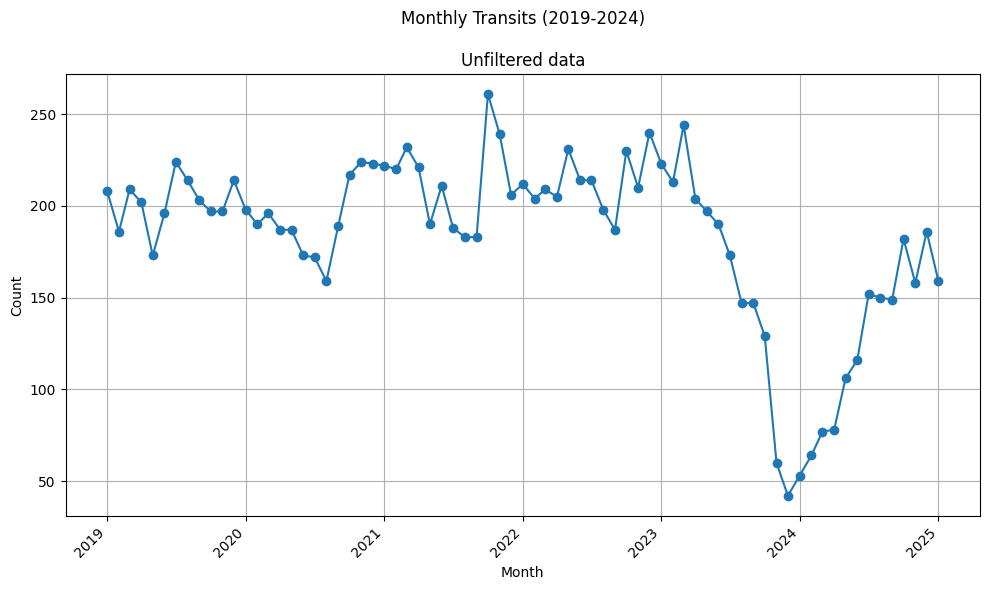

In [6]:
# Scatter plot of the count of month column in Bulk_PA_original_data_copy
monthly_counts = Bulk_PA_original_data_copy.groupby('month').size().reset_index(name='count')

# Filter data to be between 2019 and 2025
monthly_counts_filtered = monthly_counts[(monthly_counts['month'] >= '2019-01-01') & (monthly_counts['month'] <= '2025-01-01')]


# Create plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(monthly_counts_filtered['month'], monthly_counts_filtered['count'], marker='o')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly Transits (2019-2024)\n\nUnfiltered data')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

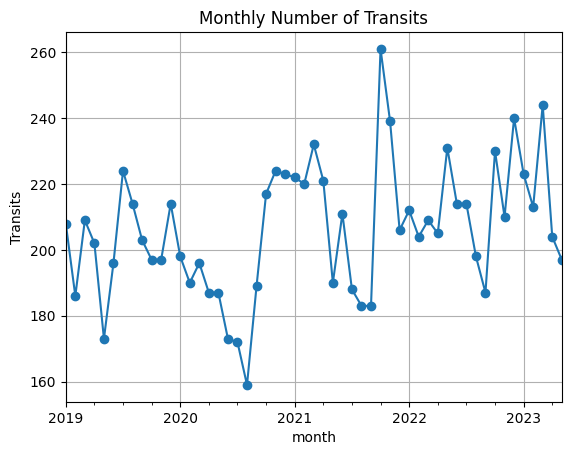

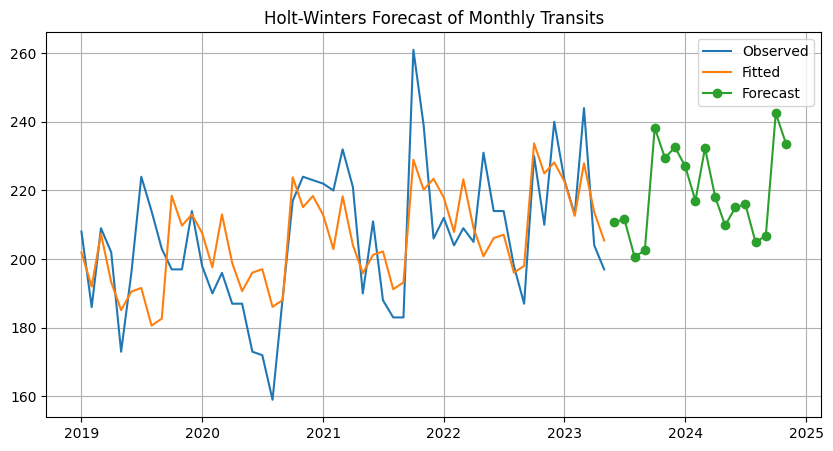

alpha: 1.50954120178117e-08
beta : 7.2160113032506825e-12
gamma: 1.9467097236776817e-10
phi  : 0.9949999998743079

Initial values:
  Initial level:               194.9542986992795
  Initial trend:               0.4892105520379322
  Seasonal initial values:     [  6.49338654  -3.93715613  11.0162455   -3.6119721  -12.23038979
  -7.30083549  -6.73177285 -18.16338779 -16.59148689  18.73420654
   9.56335714  12.38977216]

Sum of Squared Errors (SSE):  11420.08


In [7]:
# Holt-Winters time-series decomposition

# Group by month to get the number of transits
monthly_transits = Bulk_PA_original_data_copy_train.groupby('month').size().rename("number_transits")
monthly_transits = monthly_transits.asfreq('MS')  # Ensure monthly frequency

# Plot the original series
monthly_transits.plot(title="Monthly Number of Transits", marker='o')
plt.ylabel("Transits")
plt.grid(True)
plt.show()

# Holt-Winters model (additive seasonality if there is clear monthly seasonality)
model = ExponentialSmoothing(
    monthly_transits,
    trend='add',
    damped_trend=True,
    seasonal='add',
    seasonal_periods=12,
    initialization_method='estimated'
)
fit = model.fit(optimized=True)

# Forecast the next 18 months
forecast = fit.forecast(18)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(monthly_transits, label='Observed')
plt.plot(fit.fittedvalues, label='Fitted')
plt.plot(forecast, label='Forecast', marker='o')
plt.title('Holt-Winters Forecast of Monthly Transits')
plt.legend()
plt.grid(True)
plt.show()

# Print smoothing parameters
params = fit.params
print("alpha:", params.get("smoothing_level"))
print("beta :", params.get("smoothing_trend"))
print("gamma:", params.get("smoothing_seasonal"))
print("phi  :", params.get("damping_trend"))

print("\nInitial values:")
print(f"  Initial level:               {params.get('initial_level', 'N/A')}")
print(f"  Initial trend:               {params.get('initial_trend', 'N/A')}")
print(f"  Seasonal initial values:     {params.get('initial_seasons', 'N/A')}")

# Print SSE
print(f"\nSum of Squared Errors (SSE):  {fit.sse:.2f}")

In [8]:
''' Remove this code!!!'''
none_count = Bulk_PA_original_data_copy['commodity'].isnull().sum()
print(f"Number of 'None' values in 'commodity': {none_count}")
# Group by 'proxy_transit_month' and count null values in 'commodity'
none_counts_per_month = Bulk_PA_original_data_copy.groupby('month')['commodity'].apply(lambda x: x.isnull().sum()).reset_index(name='none_count')

# Display the result
#show all rows
pd.set_option('display.max_rows', None)
print(none_counts_per_month)

Number of 'None' values in 'commodity': 420
        month  none_count
0  2018-10-01           1
1  2018-11-01           4
2  2018-12-01           2
3  2019-01-01           5
4  2019-02-01           8
5  2019-03-01          12
6  2019-04-01           6
7  2019-05-01           4
8  2019-06-01           3
9  2019-07-01           4
10 2019-08-01           7
11 2019-09-01           8
12 2019-10-01           9
13 2019-11-01           6
14 2019-12-01          11
15 2020-01-01           5
16 2020-02-01           9
17 2020-03-01           5
18 2020-04-01           6
19 2020-05-01           6
20 2020-06-01           6
21 2020-07-01          10
22 2020-08-01           4
23 2020-09-01           6
24 2020-10-01           8
25 2020-11-01           6
26 2020-12-01           4
27 2021-01-01           4
28 2021-02-01          10
29 2021-03-01           7
30 2021-04-01           6
31 2021-05-01           5
32 2021-06-01           5
33 2021-07-01           3
34 2021-08-01           5
35 2021-09-01       

In [9]:
Bulk_PA_original_data_copy['commodity'].unique()

array(['Bulk Clay', 'Ferro Alloys', 'Project Cargo', 'Soybeans',
       'Durum Wheat', None, 'Corn', 'Coking Coal', 'Steels',
       'Steel Pipes', 'Petroleum Coke', 'Phosphates', 'Bulk Fertilizers',
       'Bulk Concentrates', 'Magnetite Ore', 'Grain',
       'Copper Concentrate', 'Rice', 'Alu Ingots', 'Wheat',
       'Anodes on Pallets', 'Sugar', 'Wood Pellets', 'Iron Ore Pellets',
       'Zinc Concentrates', 'Steam Coal', 'Minerals', 'Steel Billets',
       'Iron Ore Fines', 'Copper Cathodes', 'Alumina', 'Salt',
       'Copper Slag', 'Anthracite', 'Wood Chips', 'Phosphate Rock', 'HRC',
       'Steel Slabs', 'Soda Ash', 'Muriate Of Potash', 'Ores',
       'Aggregates', 'Cement', 'Furnace Slag', 'Wire Rod', 'Woodpulp',
       'Ammonium Nitrate', 'Potash', 'Iron Ore', 'General Cargo', 'Urea',
       'Gypsum', 'Soybean Meal', 'Steel Plates', 'Clinker', 'Peas',
       'Lead Concentrates', 'Coal', 'MetCoke', 'Logs', 'Pipe', 'Slag',
       'Nitrates Bagged', 'Baryte', 'Kaolin', 'Bauxite', 

## **Final Data** (cleaned data)

In [10]:
# Bulk_PA_original_data_copy to timestamp & datetime
Bulk_PA_final['proxy_transit_month'] = Bulk_PA_final['proxy_transit_month'].dt.to_timestamp()
Bulk_PA_final['proxy_transit_month'] = pd.to_datetime(Bulk_PA_final['proxy_transit_month'])


In [11]:
# Split Bulk_PA_original_data_copy for training & forecast - before & during El-Nino
Bulk_PA_final_train = Bulk_PA_final[(Bulk_PA_final['proxy_transit_month'] >= '2019-04-01') & (Bulk_PA_final['proxy_transit_month'] < '2023-06-01')]
Bulk_PA_final_observed = Bulk_PA_final[(Bulk_PA_final['proxy_transit_month'] >= '2023-06-01') & (Bulk_PA_final['proxy_transit_month'] < '2024-11-01')]

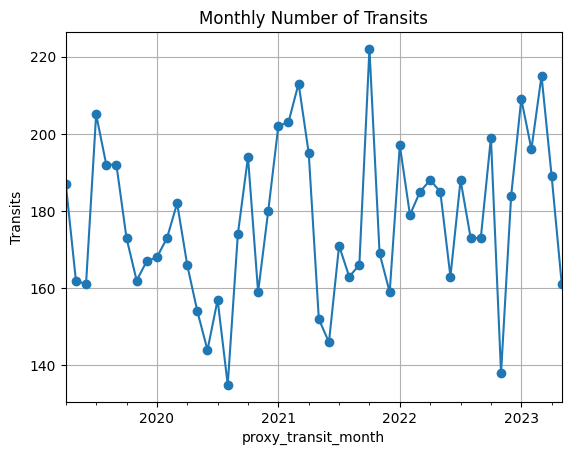

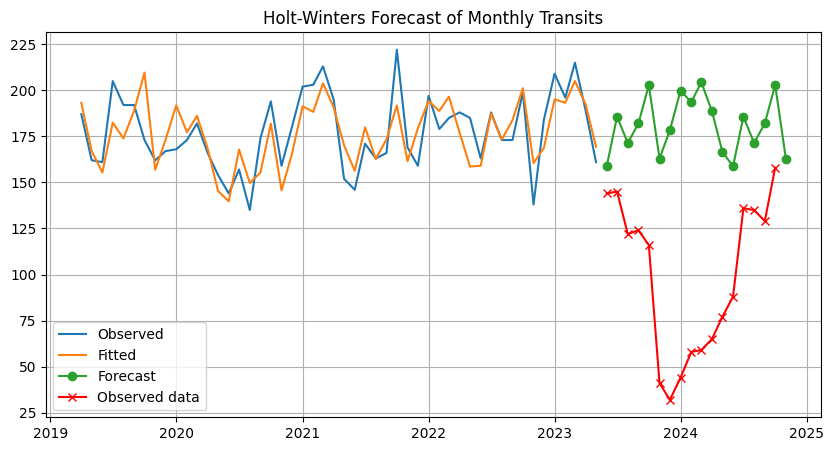

alpha: 0.3212965761276422
beta : 2.838724986524614e-11
gamma: 2.519257656757175e-10
phi  : 0.8713053729039473

Initial values:
  Initial level:               189.15462712318615
  Initial trend:               -3.0610651217688556
  Seasonal initial values:     [  6.68380828 -15.16612777 -23.14466722   3.87005099 -10.43484306
   0.1983611   21.02873627 -18.9357381   -3.44063827  18.01941688
  11.69782985  22.59840489]

Sum of Squared Errors (SSE):  8968.16


In [12]:
# Holt-Winters time-series decomposition

# Group by month to get the number of transits for the train dataset
monthly_transits_final = Bulk_PA_final_train.groupby('proxy_transit_month').size().rename("number_transits")
monthly_transits_final = monthly_transits_final.asfreq('MS')  # Ensure monthly frequency
# Group by month and count transits for the forecast dataset
monthly_counts_observed = Bulk_PA_final_observed.groupby('proxy_transit_month').size().reset_index(name='count')

# Plot the original series
monthly_transits_final.plot(title="Monthly Number of Transits", marker='o')
plt.ylabel("Transits")
plt.grid(True)
plt.show()

# Holt-Winters model (additive seasonality if there is clear monthly seasonality)
model = ExponentialSmoothing(
    monthly_transits_final,
    trend='add',
    damped_trend=True,  # Enable damping (to estimate phi)
    seasonal='add',
    seasonal_periods=12,
    initialization_method='estimated'
)
fit = model.fit(optimized=True)

# Forecast the next 18 months
forecast = fit.forecast(18)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(monthly_transits_final, label='Observed')
plt.plot(fit.fittedvalues, label='Fitted')
plt.plot(forecast, label='Forecast', marker='o')
# Plot monthly_counts_observed
plt.plot(monthly_counts_observed['proxy_transit_month'], monthly_counts_observed['count'], label='Observed data', marker='x', color='red')
plt.title('Holt-Winters Forecast of Monthly Transits')
plt.legend()
plt.grid(True)
plt.show()

# Print smoothing parameters
params = fit.params
print("alpha:", params.get("smoothing_level"))
print("beta :", params.get("smoothing_trend"))
print("gamma:", params.get("smoothing_seasonal"))
print("phi  :", params.get("damping_trend"))

print("\nInitial values:")
print(f"  Initial level:               {params.get('initial_level', 'N/A')}")
print(f"  Initial trend:               {params.get('initial_trend', 'N/A')}")
print(f"  Seasonal initial values:     {params.get('initial_seasons', 'N/A')}")

# Print SSE
print(f"\nSum of Squared Errors (SSE):  {fit.sse:.2f}")

In [13]:
monthly_counts_observed

proxy_transit_month  count
0           2023-06-01    144
1           2023-07-01    145
2           2023-08-01    122
3           2023-09-01    124
4           2023-10-01    116
5           2023-11-01     41
6           2023-12-01     32
7           2024-01-01     44
8           2024-02-01     58
9           2024-03-01     59
10          2024-04-01     65
11          2024-05-01     77
12          2024-06-01     88
13          2024-07-01    136
14          2024-08-01    135
15          2024-09-01    129
16          2024-10-01    158

In [14]:
forecast

2023-06-01    158.716050
2023-07-01    185.728399
2023-08-01    171.421440
2023-09-01    182.052845
2023-10-01    202.881652
2023-11-01    162.915812
2023-12-01    178.409722
2024-01-01    199.868740
2024-02-01    193.546249
2024-03-01    204.446037
2024-04-01    188.530755
2024-05-01    166.680221
2024-06-01    158.701161
2024-07-01    185.715425
2024-08-01    171.410136
2024-09-01    182.042996
2024-10-01    202.873071
2024-11-01    162.908335
Freq: MS, dtype: float64

In [15]:
# Convert the forecast to a DataFrame
forecast_df = pd.DataFrame(forecast, columns=['forecast'])

# Add a date column from the index
forecast_df['date'] = forecast_df.index

# Reset the index
forecast_df.reset_index(drop=True, inplace=True)

# Switch the place of columns
forecast_df = forecast_df[['date', 'forecast']]

# Set the date column as the index
forecast_df.set_index

# Display the DataFrame
forecast_df

date    forecast
0  2023-06-01  158.716050
1  2023-07-01  185.728399
2  2023-08-01  171.421440
3  2023-09-01  182.052845
4  2023-10-01  202.881652
5  2023-11-01  162.915812
6  2023-12-01  178.409722
7  2024-01-01  199.868740
8  2024-02-01  193.546249
9  2024-03-01  204.446037
10 2024-04-01  188.530755
11 2024-05-01  166.680221
12 2024-06-01  158.701161
13 2024-07-01  185.715425
14 2024-08-01  171.410136
15 2024-09-01  182.042996
16 2024-10-01  202.873071
17 2024-11-01  162.908335

In [16]:
# Merge forecast_df and monthly_counts_observed
merged_df = pd.merge(forecast_df, monthly_counts_observed, left_on='date', right_on='proxy_transit_month', how='left')
# Drop proxy_transit_month column
merged_df.drop(columns=['proxy_transit_month'], inplace=True)
# Calculate the difference in the number of transits per month in int64 type
merged_df['difference'] = merged_df['forecast'].astype(int) - merged_df['count']
# Add a total count of missed transits
print('Number of deviated transits:', merged_df['difference'].sum())
# Display the new df
merged_df

Number of deviated transits: 1413.0


date    forecast  count  difference
0  2023-06-01  158.716050  144.0        14.0
1  2023-07-01  185.728399  145.0        40.0
2  2023-08-01  171.421440  122.0        49.0
3  2023-09-01  182.052845  124.0        58.0
4  2023-10-01  202.881652  116.0        86.0
5  2023-11-01  162.915812   41.0       121.0
6  2023-12-01  178.409722   32.0       146.0
7  2024-01-01  199.868740   44.0       155.0
8  2024-02-01  193.546249   58.0       135.0
9  2024-03-01  204.446037   59.0       145.0
10 2024-04-01  188.530755   65.0       123.0
11 2024-05-01  166.680221   77.0        89.0
12 2024-06-01  158.701161   88.0        70.0
13 2024-07-01  185.715425  136.0        49.0
14 2024-08-01  171.410136  135.0        36.0
15 2024-09-01  182.042996  129.0        53.0
16 2024-10-01  202.873071  158.0        44.0
17 2024-11-01  162.908335    NaN         NaN

In [17]:
# Read Bulk_PA_ML_1 from parquet
#Bulk_PA_ML_1 = pd.read_parquet('Bulk_PA_ML_1.parquet')
#Bulk_PA_ML_1

# **Alternative to Holt-Winters: Linear regression**

## **ML2: ML - Linear Regresion** region_pair & commodity details

In [18]:
# Read Bulk_PA_ML_2 from parquet
Bulk_PA_ML_2 = pd.read_parquet('Bulk_PA_ML_2.parquet')
# See all columns
pd.set_option('display.max_columns', None)
Bulk_PA_ML_2

proxy_transit_month  voy_intake_sum  number_transits   ONI  ONI_lag_3  \
0                2019-01           69315                2  0.75       0.76   
1                2019-01           36530                1  0.75       0.76   
2                2019-01           61760                2  0.75       0.76   
3                2019-01          190931                5  0.75       0.76   
4                2019-01          192015                2  0.75       0.76   
5                2019-01           28006                1  0.75       0.76   
6                2019-01          613402               11  0.75       0.76   
7                2019-01           60565                3  0.75       0.76   
8                2019-01          137674                5  0.75       0.76   
9                2019-01           48743                1  0.75       0.76   
10               2019-01           24835                1  0.75       0.76   
11               2019-01           93486                3  0.75       0.76   
12               2019-01          345250                4  0.75       0.76   
13               2019-01          205517                5  0.75       0.76   
14               2019-01          222579                6  0.75       0.76   
15               2019-01           38567                1  0.75       0.76   
16               2019-01          166433                6  0.75       0.76   
17               2019-01           95021                3  0.75       0.76   
18               2019-01           61184                1  0.75       0.76   
19               2019-01          180733                4  0.75       0.76   
20               2019-01           41259                1  0.75       0.76   
21               2019-01           66537                2  0.75       0.76   
22               2019-01          531294               12  0.75       0.76   
23               2019-01           51118                1  0.75       0.76   
24               2019-01          106923                3  0.75       0.76   
25               2019-01          275574                6  0.75       0.76   
26               2019-01           87859                4  0.75       0.76   
27               2019-01           23246                1  0.75       0.76   
28               2019-01          312848                3  0.75       0.76   
29               2019-01           65725                2  0.75       0.76   
30               2019-01           68334                2  0.75       0.76   
31               2019-01            9698                1  0.75       0.76   
32               2019-01           54040                1  0.75       0.76   
33               2019-02           33870                1  0.72       0.90   
34               2019-02          326189                8  0.72       0.90   
35               2019-02           84575                1  0.72       0.90   
36               2019-02          931260               17  0.72       0.90   
37               2019-02          194448                8  0.72       0.90   
38               2019-02          124005                5  0.72       0.90   
39               2019-02          136895                3  0.72       0.90   
40               2019-02           57892                2  0.72       0.90   
41               2019-02          147170                4  0.72       0.90   
42               2019-02          260355                6  0.72       0.90   
43               2019-02           58063                2  0.72       0.90   
44               2019-02          110167                3  0.72       0.90   
45               2019-02          135352                4  0.72       0.90   
46               2019-02           15684                1  0.72       0.90   
47               2019-02          112900                2  0.72       0.90   
48               2019-02           94047                3  0.72       0.90   
49               2019-02           28187                1  0.72       0.90   
50               2019-02   

In [19]:
# Linear regression with Bulk_PA_ML_2
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Sort the data by date
Bulk_PA_ML_2 = Bulk_PA_ML_2.sort_values(by=['proxy_transit_month'])

# Create a TimeSeriesSplit object with n_splits=5
tscv = TimeSeriesSplit(n_splits=5)

# Prepare the data
X = Bulk_PA_ML_2[['ONI_lag_3', 'water_level_m_lag_3', 'VLSFO', 'Coal_Australian', 'Wheat_HRW', 'distance_94']]
y = Bulk_PA_ML_2['number_transits']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Iterate through the splits and train/evaluate the model
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    print("-" * 20)  # Separator between splits

Mean Squared Error: 36.340221222143654
R-squared: -0.18448307924116603
--------------------
Mean Squared Error: 36.05412239957021
R-squared: -0.040700930316188044
--------------------
Mean Squared Error: 30.38403044664107
R-squared: 0.0033973276917887985
--------------------
Mean Squared Error: 37.12403533559409
R-squared: 0.031212759508706056
--------------------
Mean Squared Error: 10.800525738518697
R-squared: -0.02695540113606354
--------------------


## **ML4: statistical Linear Regression** - aggregated data

In [20]:
import statsmodels.formula.api as smf
from sklearn.model_selection import TimeSeriesSplit

# Read Bulk_PA_ML_4
Bulk_PA_ML_4 = pd.read_parquet('Bulk_PA_ML_4.parquet')

# Sort the data by date
Bulk_PA_ML_4 = Bulk_PA_ML_4.sort_values(by=['proxy_transit_month'])

# Create a TimeSeriesSplit object with n_splits=5
tscv = TimeSeriesSplit(n_splits=5)

# Convert proxy month to timestamp
Bulk_PA_ML_4['proxy_transit_month'] = Bulk_PA_ML_4['proxy_transit_month'].dt.to_timestamp()

# Create categorical features for dates & to object
Bulk_PA_ML_4['year'] = Bulk_PA_ML_4['proxy_transit_month'].dt.year.astype(str)
Bulk_PA_ML_4['month'] = Bulk_PA_ML_4['proxy_transit_month'].dt.month.astype(str)

# Define the formula for the model
formula = 'number_transits ~ year + month + VLSFO + Wheat_HRW'

# Iterate through the splits and train/evaluate the model
for train_index, test_index in tscv.split(Bulk_PA_ML_4):
    train_data = Bulk_PA_ML_4.iloc[train_index].copy()
    test_data = Bulk_PA_ML_4.iloc[test_index].copy()

    # Refit the model with the combined categories from train and test data
    # Get unique categories from both train and test data
    all_years = pd.concat([train_data['year'], test_data['year']]).unique()
    all_months = pd.concat([train_data['month'], test_data['month']]).unique()

    # Add these levels to the categorical dtype of the 'year' and 'month' column
    train_data['year'] = pd.Categorical(train_data['year'], categories=all_years)
    train_data['month'] = pd.Categorical(train_data['month'], categories=all_months)
    test_data['year'] = pd.Categorical(test_data['year'], categories=all_years)
    test_data['month'] = pd.Categorical(test_data['month'], categories=all_months)

    # Fit the model using smf.ols
    model = smf.ols(formula=formula, data=train_data).fit()

# Print model summary for each split
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        number_transits   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     3.151
Date:                Tue, 27 May 2025   Prob (F-statistic):            0.00126
Time:                        22:50:12   Log-Likelihood:                -273.60
No. Observations:                  60   AIC:                             583.2
Df Residuals:                      42   BIC:                             620.9
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       93.2425     28.618      3.258   

In [21]:
Bulk_PA_ML_4

proxy_transit_month  voy_intake_sum  number_transits   ONI  ONI_lag_3  \
0           2019-01-01         4567001              106  0.75       0.76   
1           2019-02-01         4502390              106  0.72       0.90   
2           2019-03-01         4871481              115  0.71       0.81   
3           2019-04-01         5887808              152  0.66       0.75   
4           2019-05-01         5420541              135  0.54       0.72   
5           2019-06-01         4940326              127  0.45       0.71   
6           2019-07-01         6742429              161  0.28       0.66   
7           2019-08-01         6478459              166  0.14       0.54   
8           2019-09-01         6438120              157  0.19       0.45   
9           2019-10-01         5792858              150  0.35       0.28   
10          2019-11-01         6045133              137  0.51       0.14   
11          2019-12-01         5641736              141  0.55       0.19   
12          2020-01-01         6308485              139  0.50       0.35   
13          2020-02-01         6005863              154  0.48       0.51   
14          2020-03-01         6181170              158  0.40       0.55   
15          2020-04-01         5531472              145  0.19       0.50   
16          2020-05-01         5304949              130 -0.08       0.48   
17          2020-06-01         4739050              122 -0.30       0.40   
18          2020-07-01         5552625              141 -0.41       0.19   
19          2020-08-01         5154235              119 -0.57      -0.08   
20          2020-09-01         7144417              160 -0.89      -0.30   
21          2020-10-01         8334668              175 -1.17      -0.41   
22          2020-11-01         6803125              149 -1.27      -0.57   
23          2020-12-01         8368943              170 -1.19      -0.89   
24          2021-01-01         8849101              189 -1.05      -1.17   
25          2021-02-01         7797253              187 -0.93      -1.27   
26          2021-03-01         8838532              201 -0.84      -1.19   
27          2021-04-01         8134987              183 -0.66      -1.05   
28          2021-05-01         6428715              143 -0.48      -0.93   
29          2021-06-01         5512902              130 -0.38      -0.84   
30          2021-07-01         7289073              164 -0.40      -0.66   
31          2021-08-01         6590912              159 -0.49      -0.48   
32          2021-09-01         6937534              158 -0.67      -0.38   
33          2021-10-01         9939977              218 -0.81      -0.40   
34          2021-11-01         7425212              168 -0.98      -0.49   
35          2021-12-01         6668200              157 -0.98      -0.67   
36          2022-01-01         8790615              196 -0.97      -0.81   
37          2022-02-01         7770064              177 -0.93      -0.98   
38          2022-03-01         7977601              184 -0.99      -0.98   
39          2022-04-01         8118490              188 -1.06      -0.97   
40          2022-05-01         7852503              185 -0.99      -0.93   
41          2022-06-01         6487533              158 -0.85      -0.99   
42          2022-07-01         8300629              188 -0.81      -1.06   
43          2022-08-01         7497504              173 -0.91      -0.99   
44          2022-09-01         7332607              172 -1.01      -0.85   
45          2022-10-01         8997352              196 -0.99      -0.81   
46          2022-11-01         6034383              136 -0.92      -0.91   
47          2022-12-01         8422354              183 -0.83      -1.01   
48          2023-01-01         9224837              206 -0.68      -0.99   
49          2023-02-01         9096276              195 -0.43      -0.92   
50          2023-03-01         9524012              212 -0.15      -0.83   
51          2023-04-01         7698538             

## **ML5: statistical Linear Regression** - region pairs

### **Before El-Nino model**

In [22]:
# Block 1 - initialization and correlation analysis before El-Nino
#Read Bulk_PA_ML_5
Bulk_PA_ML_5 = pd.read_parquet('Bulk_PA_ML_5.parquet')

# Sort the data by date
Bulk_PA_ML_5 = Bulk_PA_ML_5.sort_values(by=['proxy_transit_month']).reset_index(drop=True)

# Convert proxy_transit_month to period M
Bulk_PA_ML_5['proxy_transit_month'] = Bulk_PA_ML_5['proxy_transit_month'].dt.to_timestamp()

# Filter the data to exclude El-Nino data
Bulk_PA_ML_5_normal = Bulk_PA_ML_5[Bulk_PA_ML_5['proxy_transit_month'] < '2023-06-01'].copy()

# Correlation analysis between variables
# Select the columns for correlation analysis
columns_for_correlation = ['voy_intake_sum',	'number_transits',	'ONI',	'ONI_lag_1',	'ONI_lag_2',	'ONI_lag_3',	'water_level_m',	'water_level_m_lag_1',
                           'water_level_m_lag_2',	'water_level_m_lag_3',	'IFO380',	'Coal_Australian',	'Soybeans',	'Maize_Corn',	'Wheat_HRW',	'Phosphate_rock',	'Copper',
                           'voy_sea_duration_h',	'distance_94',
                           'vsl_dwt',	'fuel_consumption_mt', 'Australia-NE_America',	'E_Asia-NE_America',	'E_Asia-SE_America',
                           'Europe_N_Africa-NW_America',	'Europe_N_Africa-SW_America',	'NE_America-NW_America',	'NE_America-SW_America',	'NW_America-SE_America',
                           'SE_America-SW_America', 'dry_season',	'rain_season_1st_half',	'rain_season_2nd_half']
# Calculate the correlation matrix
correlation_matrix = Bulk_PA_ML_5_normal[columns_for_correlation].corr()

# Highlight the potential colinearrity

def highlight_cells(val):
  """
  Highlights cells with values greater than 0.5 in bold red.
  """
  if abs(val) > 0.5 and val != 1:
    color = 'red'
    weight = 'bold'
  else:
    color = 'black'
    weight = 'normal'
  return f'color: {color}; font-weight: {weight}'

# Apply the styling function to the correlation matrix
highlighted_correlation_matrix = correlation_matrix.style.applymap(highlight_cells)

# Display the styled correlation matrix
display(highlighted_correlation_matrix)

<ipython-input-22-ebe437a3e884>:40: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  highlighted_correlation_matrix = correlation_matrix.style.applymap(highlight_cells)


In [23]:
Bulk_PA_ML_5_normal.head()

proxy_transit_month                region_pairs  voy_intake_sum  \
0          2019-01-01        Australia-NE_America          167605   
1          2019-01-01           E_Asia-NE_America         1497212   
2          2019-01-01           E_Asia-SE_America          148626   
3          2019-01-01  Europe_N_Africa-NW_America          905399   
4          2019-01-01  Europe_N_Africa-SW_America          339825   

   number_transits   ONI  ONI_lag_1  ONI_lag_2  ONI_lag_3  water_level_m  \
0                5  0.75       0.81        0.9       0.76      26.188514   
1               34  0.75       0.81        0.9       0.76      26.188514   
2                4  0.75       0.81        0.9       0.76      26.188514   
3               19  0.75       0.81        0.9       0.76      26.188514   
4               11  0.75       0.81        0.9       0.76      26.188514   

   water_level_m_lag_1  water_level_m_lag_2  water_level_m_lag_3  IFO380  \
0            26.786906            26.810513            26.664789   406.0   
1            26.786906            26.810513            26.664789   406.0   
2            26.786906            26.810513            26.664789   406.0   
3            26.786906            26.810513            26.664789   406.0   
4            26.786906            26.810513            26.664789   406.0   

   Coal_Australian  Soybeans  Maize_Corn   Wheat_HRW  Phosphate_rock  Copper  \
0            98.56    381.96  166.743164  209.806356           102.5  5939.1   
1            98.56    381.96  166.743164  209.806356           102.5  5939.1   
2            98.56    381.96  166.743164  209.806356           102.5  5939.1   
3            98.56    381.96  166.743164  209.806356           102.5  5939.1   
4            98.56    381.96  166.743164  209.806356           102.5  5939.1   

   Soybean_meal       Sugar   Urea  Potassium_chloride    Zinc  Wood_Pellets  \
0        362.01  563.721334  260.0               215.5  2569.7         273.9   
1        362.01  563.721334  260.0               215.5  2569.7         273.9   
2        362.01  563.721334  260.0               215.5  2569.7         273.9   
3        362.01  563.721334  260.0               215.5  2569.7         273.9   
4        362.01  563.721334  260.0               215.5  2569.7         273.9   

   Coking_Coal  HRC_Steel   Steel  Petroleum_Coke  Salt  voy_sea_duration_h  \
0       185.15      694.0  534.94            90.0  25.0          760.456667   
1       185.15      694.0  534.94            90.0  25.0          977.374020   
2       185.15      694.0  534.94            90.0  25.0         1127.104167   
3       185.15      694.0  534.94            90.0  25.0          808.073684   
4       185.15      694.0  534.94            90.0  25.0          667.598485   

    distance_94  shortest_distance_nm  shortest_distance_day  \
0   9329.314167                9423.0                 30.200   
1  11627.729250               10309.0                 33.040   
2  12639.290333                8463.0                 27.130   
3   9791.127333                8064.5                 25.845   
4   8659.646667                8023.0                 25.710   

   second_shortest_distance_nm  second_shortest_distance_day  rerouting_nm  \
0                      13778.0                         44.16        4355.0   
1                      16008.0                         51.31        5699.0   
2                      14312.0                         45.87        5849.0   
3                      13603.5                         43.60        5539.0   
4                      11007.0                         35.28        2984.0   

   rerouting_day  vsl_dwt  fuel_consumption_mt   cargo_value   canal_fee  \
0         13.960  35550.0           664.699685  4.877738e+06  139087.500   
1         18.270  55564.0           919.193310  1.860352e+07  198819.425   
2         18.740  43999.0          1050.212538  5.119287e+06  165052.100   
3         17.755  55090.0           703.772659  1.427129e+07  198003.500   
4 

In [24]:
# Block 2 - linear regression model
import statsmodels.formula.api as smf
from sklearn.model_selection import TimeSeriesSplit

# Create a TimeSeriesSplit object with n_splits=5
tscv = TimeSeriesSplit(n_splits=5)

# Define the formula for the model
formula = 'number_transits ~ region_pairs'
#formula = 'number_transits ~ region_pairs + IFO380	+ Coal_Australian + Soybeans + Maize_Corn +	Wheat_HRW +	Phosphate_rock +	Copper +	distance_94 + rain_season_1st_half +	rain_season_2nd_half'

# Convert 'region_pairs' to a categorical type using categories from the whole DataFrame
# This ensures all possible categories are known before splitting
Bulk_PA_ML_5_normal['region_pairs'] = pd.Categorical(Bulk_PA_ML_5_normal['region_pairs'],
                                                     categories=Bulk_PA_ML_5_normal['region_pairs'].unique())

# Iterate through the splits and train/evaluate the model
for train_index, test_index in tscv.split(Bulk_PA_ML_5_normal):
    train_data_ml_5_normal = Bulk_PA_ML_5_normal.iloc[train_index]
    test_data_ml_5_normal = Bulk_PA_ML_5_normal.iloc[test_index]

    # Fit the model using smf.ols
    model_ml_5_normal = smf.ols(formula=formula, data=train_data_ml_5_normal).fit()

    # Make predictions
    y_pred_ml_5_normal = model_ml_5_normal.predict(test_data_ml_5_normal)

# Store the last model's parameters
LR_5_normal_params = model_ml_5_normal.params

# Print model summary (includes parameters and significance)
print(model_ml_5_normal.summary())

                            OLS Regression Results                            
Dep. Variable:        number_transits   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     248.1
Date:                Tue, 27 May 2025   Prob (F-statistic):          6.08e-146
Time:                        22:50:13   Log-Likelihood:                -1327.8
No. Observations:                 390   AIC:                             2674.
Df Residuals:                     381   BIC:                             2709.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

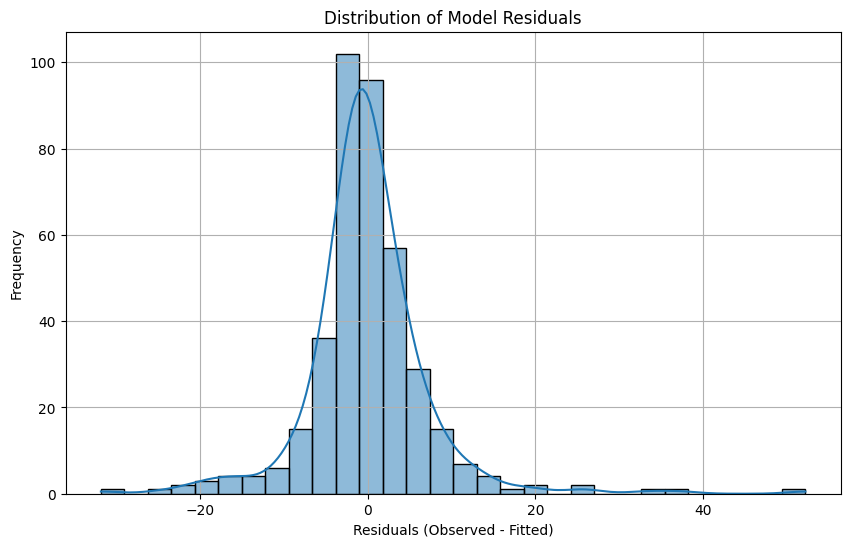

count    3.900000e+02
mean     1.399223e-14
std      7.292597e+00
min     -3.179545e+01
25%     -2.755682e+00
50%     -3.181818e-01
75%      2.681818e+00
max      5.220455e+01
Name: residuals, dtype: float64


In [25]:
# Distribution of the errors from the model

# Calculate the residuals (this is correct as model_ml_5_normal.resid corresponds to the last trained fold)
Bulk_PA_ML_5_normal['residuals'] = model_ml_5_normal.resid

# Plot the distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(Bulk_PA_ML_5_normal['residuals'], bins=30, kde=True)
plt.title('Distribution of Model Residuals')
plt.xlabel('Residuals (Observed - Fitted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Main statistics of the distribution
print(Bulk_PA_ML_5_normal['residuals'].describe())


In [26]:
# Bulk_PA_ML_5_normal tp parquet
Bulk_PA_ML_5_normal.to_parquet('Bulk_PA_before_ElNino.parquet')

### **El-Nino model**

In [27]:
# Block 1 - initialization and correlation analysis before El-Nino

# Filter the data to only keep El-Nino data after 06-2023 and before 09-2024
Bulk_PA_ML_5_ElNino = Bulk_PA_ML_5[(Bulk_PA_ML_5['proxy_transit_month'] >= '2023-06-01') & (Bulk_PA_ML_5['proxy_transit_month'] < '2024-09-01')].copy()

# Correlation analysis between variables
# Select the columns for correlation analysis
columns_for_correlation = ['voy_intake_sum',	'number_transits',	'ONI',	'ONI_lag_1',	'ONI_lag_2',	'ONI_lag_3',	'water_level_m',	'water_level_m_lag_1',
                           'water_level_m_lag_2',	'water_level_m_lag_3',	'IFO380',	'Coal_Australian',	'Soybeans',	'Maize_Corn',	'Wheat_HRW',	'Phosphate_rock',	'Copper',
                           'voy_sea_duration_h',	'distance_94',
                           'vsl_dwt',	'fuel_consumption_mt', 'Australia-NE_America',	'E_Asia-NE_America',	'E_Asia-SE_America',
                           'Europe_N_Africa-NW_America',	'Europe_N_Africa-SW_America',	'NE_America-NW_America',	'NE_America-SW_America',	'NW_America-SE_America',
                           'SE_America-SW_America', 'dry_season',	'rain_season_1st_half',	'rain_season_2nd_half']
# Calculate the correlation matrix
correlation_matrix_ElNino = Bulk_PA_ML_5_ElNino[columns_for_correlation].corr()

# Apply the styling function to the correlation matrix
highlighted_correlation_matrixElNino = correlation_matrix_ElNino.style.applymap(highlight_cells)

# Display the styled correlation matrix
display(highlighted_correlation_matrixElNino)

<ipython-input-27-4d9ce6ed88e4>:18: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  highlighted_correlation_matrixElNino = correlation_matrix_ElNino.style.applymap(highlight_cells)


In [28]:
# Block 1 - initialization and correlation analysis during and after El-Nino

# Create a TimeSeriesSplit object with n_splits=5
tscv = TimeSeriesSplit(n_splits=5)

# Define the formula for the model

formula = 'number_transits ~ region_pairs + ONI_lag_3'
# 'number_transits ~ region_pairs + water_level_m +  ONI_lag_3 + IFO380 + Maize_Corn + fuel_consumption_mt + rain_season_1st_half + rain_season_2nd_half'

# Convert 'region_pairs' to a categorical type using categories from the whole DataFrame
# This ensures all possible categories are known before splitting
Bulk_PA_ML_5_ElNino['region_pairs'] = pd.Categorical(Bulk_PA_ML_5_ElNino['region_pairs'],
                                                     categories=Bulk_PA_ML_5_ElNino['region_pairs'].unique())

# Iterate through the splits and train/evaluate the model
for train_index, test_index in tscv.split(Bulk_PA_ML_5_ElNino):
    train_data_ElNino = Bulk_PA_ML_5_ElNino.iloc[train_index]
    test_data_ElNino = Bulk_PA_ML_5_ElNino.iloc[test_index]

    # Fit the model using smf.ols
    model_ml_5_ElNino = smf.ols(formula=formula, data=train_data_ElNino).fit()

    # Make predictions
    y_pred = model_ml_5_ElNino.predict(test_data_ElNino)

# Store the last model's parameters
LR_5_ElNino_params = model_ml_5_ElNino.params

# Print model summary (includes parameters and significance)
print(model_ml_5_ElNino.summary())

                            OLS Regression Results                            
Dep. Variable:        number_transits   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     26.98
Date:                Tue, 27 May 2025   Prob (F-statistic):           5.89e-22
Time:                        22:50:14   Log-Likelihood:                -309.30
No. Observations:                 100   AIC:                             638.6
Df Residuals:                      90   BIC:                             664.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

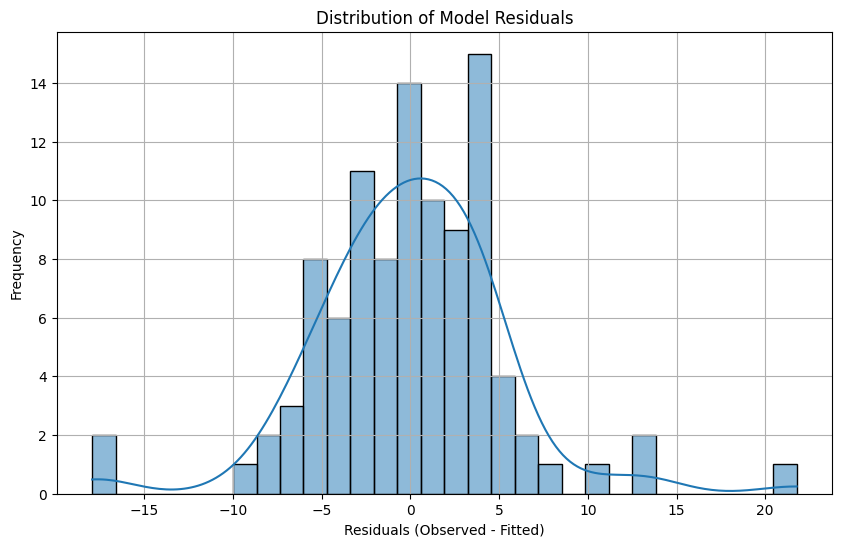

count    1.000000e+02
mean     2.511769e-14
std      5.360655e+00
min     -1.794719e+01
25%     -2.830491e+00
50%     -3.363838e-02
75%      3.283693e+00
max      2.177370e+01
Name: residuals, dtype: float64


In [29]:
# Distribution of the errors from the model

# Calculate the residuals (this is correct as model_ml_5_ElNino.resid corresponds to the last trained fold)
Bulk_PA_ML_5_ElNino['residuals'] = model_ml_5_ElNino.resid

# Plot the distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(Bulk_PA_ML_5_ElNino['residuals'], bins=30, kde=True)
plt.title('Distribution of Model Residuals')
plt.xlabel('Residuals (Observed - Fitted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Main statistics of the distribution
print(Bulk_PA_ML_5_ElNino['residuals'].describe())


### **Forecast 2023-2024 No ElNino**

In [30]:
# LR_5_normal_params to df - Linear regression parameters with data before El-Nino
LR_5_normal_params_df = pd.DataFrame(LR_5_normal_params).T
LR_5_normal_params_df
# Remove ']' and 'region_pairs[T.' in the column names
LR_5_normal_params_df.columns = LR_5_normal_params_df.columns.str.replace(']', '')
LR_5_normal_params_df.columns = LR_5_normal_params_df.columns.str.replace('region_pairs[T.', '')
LR_5_normal_params_df

Intercept  E_Asia-NE_America  E_Asia-SE_America  \
0   2.777778          56.017677            3.40404   

   Europe_N_Africa-NW_America  Europe_N_Africa-SW_America  \
0                   19.540404                    9.540404   

   NE_America-NW_America  NE_America-SW_America  NW_America-SE_America  \
0               18.40404              30.511111               6.858586   

   SE_America-SW_America  
0               4.822222

In [31]:
# Forecast the transits for the El-Nino data
# Initialize the 'forecast' column with NaNs
Bulk_PA_ML_5_ElNino['forecast'] = np.nan

# Loop through each row of Bulk_PA_ML_5_ElNino using the index
for index in Bulk_PA_ML_5_ElNino.index:
    # Initialize the sum with the intercept value
    sum_value = LR_5_normal_params_df['Intercept'].iloc[0]

    # Loop through each column of LR_5_normal_params_df (excluding 'Intercept')
    for column_name in LR_5_normal_params_df.columns[1:]:
        # Get the corresponding column value from Bulk_PA_ML_5_ElNino
        # Use .loc with the index and column name
        column_value = Bulk_PA_ML_5_ElNino.loc[index, column_name]

        # Multiply the column value with the parameter value and add to the sum
        sum_value += LR_5_normal_params_df[column_name].iloc[0] * column_value

    # Assign the final sum to the 'forecast' column for the current row
    Bulk_PA_ML_5_ElNino.loc[index, 'forecast'] = sum_value

# Display the DataFrame with the forecast column
display(Bulk_PA_ML_5_ElNino.head())

proxy_transit_month                region_pairs  voy_intake_sum  \
467          2023-06-01       SE_America-SW_America          284786   
468          2023-06-01           E_Asia-SE_America           37144   
469          2023-06-01       NW_America-SE_America          836387   
470          2023-06-01       NE_America-SW_America          777123   
471          2023-06-01  Europe_N_Africa-SW_America          218320   

     number_transits   ONI  ONI_lag_1  ONI_lag_2  ONI_lag_3  water_level_m  \
467                8  0.77       0.48       0.16      -0.15       24.31857   
468                2  0.77       0.48       0.16      -0.15       24.31857   
469               17  0.77       0.48       0.16      -0.15       24.31857   
470               22  0.77       0.48       0.16      -0.15       24.31857   
471                8  0.77       0.48       0.16      -0.15       24.31857   

     water_level_m_lag_1  water_level_m_lag_2  water_level_m_lag_3  \
467            24.667956            25.300737            25.745768   
468            24.667956            25.300737            25.745768   
469            24.667956            25.300737            25.745768   
470            24.667956            25.300737            25.745768   
471            24.667956            25.300737            25.745768   

         IFO380  Coal_Australian  Soybeans  Maize_Corn  Wheat_HRW  \
467  489.318182           139.42    591.89  266.867798      345.5   
468  489.318182           139.42    591.89  266.867798      345.5   
469  489.318182           139.42    591.89  266.867798      345.5   
470  489.318182           139.42    591.89  266.867798      345.5   
471  489.318182           139.42    591.89  266.867798      345.5   

     Phosphate_rock   Copper  Soybean_meal       Sugar   Urea  \
467           344.5  8396.52        491.56  909.185288  287.5   
468           344.5  8396.52        491.56  909.185288  287.5   
469           344.5  8396.52        491.56  909.185288  287.5   
470           344.5  8396.52        491.56  909.185288  287.5   
471           344.5  8396.52        491.56  909.185288  287.5   

     Potassium_chloride     Zinc  Wood_Pellets  Coking_Coal  HRC_Steel  \
467               328.0  2375.45         419.1       226.38     1135.0   
468               328.0  2375.45         419.1       226.38     1135.0   
469               328.0  2375.45         419.1       226.38     1135.0   
470               328.0  2375.45         419.1       226.38     1135.0   
471               328.0  2375.45         419.1       226.38     1135.0   

      Steel  Petroleum_Coke  Salt  voy_sea_duration_h   distance_94  \
467  523.32           130.0  25.0          451.725000   2850.443453   
468  523.32           130.0  25.0         1382.900000  11778.460371   
469  523.32           130.0  25.0          388.724510   1860.826586   
470  523.32           130.0  25.0          453.330303   3454.833727   
471  523.32           130.0  25.0          827.022917   5485.504805   

     shortest_distance_nm  shortest_distance_day  second_shortest_distance_nm  \
467                2021.0                  6.475                       8764.0   
468                8463.0                 27.130                      14312.0   
469                3661.5                 11.735                      12510.5   
470                2940.0                  9.425                      10267.5   
471                8023.0                 25.710                      11007.0   

     second_shortest_distance_day  rerouting_nm  rerouting_day  vsl_dwt  \
467                        28.090        6743.0         21.615  37831.5   
468                        45.870        5849.0         18.740  20669.0   
469                        40.095        8849.0         28.360  63301.0   
470                        32.910        7327.5         23.485  37963.0   
471                        35.280        2984.0          9.570  35869.5   

     fuel_consumption_mt   cargo_value   canal_fee  Australia-NE_Americ

In [32]:
# LR_5_ElNino_params to df - Linear regression parameters with data during El-Nino
LR_5_ElNino_params_df = pd.DataFrame(LR_5_ElNino_params).T
LR_5_ElNino_params_df
# Remove ']' and 'region_pairs[T.' in the column names
LR_5_ElNino_params_df.columns = LR_5_ElNino_params_df.columns.str.replace(']', '')
LR_5_ElNino_params_df.columns = LR_5_ElNino_params_df.columns.str.replace('region_pairs[T.', '')
LR_5_ElNino_params_df

Intercept  E_Asia-SE_America  NW_America-SE_America  NE_America-SW_America  \
0    8.66847           0.034918               7.956593              14.456593   

   Europe_N_Africa-SW_America  Europe_N_Africa-NW_America  E_Asia-NE_America  \
0                    3.645181                    7.580939          25.504016   

   NE_America-NW_America  Australia-NE_America  ONI_lag_3  
0              11.734785              -1.36703  -5.913651

In [33]:
# Forecast the transits for the El-Nino data
# Initialize the 'forecast' column with NaNs
Bulk_PA_ML_5_ElNino['forecastElNino'] = np.nan

# Loop through each row of Bulk_PA_ML_5_ElNino using the index
for index in Bulk_PA_ML_5_ElNino.index:
    # Initialize the sum with the intercept value
    sum_value = LR_5_ElNino_params_df['Intercept'].iloc[0]

    # Loop through each column of LR_5_normal_params_df (excluding 'Intercept')
    for column_name in LR_5_ElNino_params_df.columns[1:]:
        # Get the corresponding column value from Bulk_PA_ML_5_ElNino
        # Use .loc with the index and column name
        column_value = Bulk_PA_ML_5_ElNino.loc[index, column_name]

        # Multiply the column value with the parameter value and add to the sum
        sum_value += LR_5_ElNino_params_df[column_name].iloc[0] * column_value

    # Assign the final sum to the 'forecast' column for the current row
    Bulk_PA_ML_5_ElNino.loc[index, 'forecastElNino'] = sum_value

# Display the DataFrame with the forecast column
display(Bulk_PA_ML_5_ElNino.head())

proxy_transit_month                region_pairs  voy_intake_sum  \
467          2023-06-01       SE_America-SW_America          284786   
468          2023-06-01           E_Asia-SE_America           37144   
469          2023-06-01       NW_America-SE_America          836387   
470          2023-06-01       NE_America-SW_America          777123   
471          2023-06-01  Europe_N_Africa-SW_America          218320   

     number_transits   ONI  ONI_lag_1  ONI_lag_2  ONI_lag_3  water_level_m  \
467                8  0.77       0.48       0.16      -0.15       24.31857   
468                2  0.77       0.48       0.16      -0.15       24.31857   
469               17  0.77       0.48       0.16      -0.15       24.31857   
470               22  0.77       0.48       0.16      -0.15       24.31857   
471                8  0.77       0.48       0.16      -0.15       24.31857   

     water_level_m_lag_1  water_level_m_lag_2  water_level_m_lag_3  \
467            24.667956            25.300737            25.745768   
468            24.667956            25.300737            25.745768   
469            24.667956            25.300737            25.745768   
470            24.667956            25.300737            25.745768   
471            24.667956            25.300737            25.745768   

         IFO380  Coal_Australian  Soybeans  Maize_Corn  Wheat_HRW  \
467  489.318182           139.42    591.89  266.867798      345.5   
468  489.318182           139.42    591.89  266.867798      345.5   
469  489.318182           139.42    591.89  266.867798      345.5   
470  489.318182           139.42    591.89  266.867798      345.5   
471  489.318182           139.42    591.89  266.867798      345.5   

     Phosphate_rock   Copper  Soybean_meal       Sugar   Urea  \
467           344.5  8396.52        491.56  909.185288  287.5   
468           344.5  8396.52        491.56  909.185288  287.5   
469           344.5  8396.52        491.56  909.185288  287.5   
470           344.5  8396.52        491.56  909.185288  287.5   
471           344.5  8396.52        491.56  909.185288  287.5   

     Potassium_chloride     Zinc  Wood_Pellets  Coking_Coal  HRC_Steel  \
467               328.0  2375.45         419.1       226.38     1135.0   
468               328.0  2375.45         419.1       226.38     1135.0   
469               328.0  2375.45         419.1       226.38     1135.0   
470               328.0  2375.45         419.1       226.38     1135.0   
471               328.0  2375.45         419.1       226.38     1135.0   

      Steel  Petroleum_Coke  Salt  voy_sea_duration_h   distance_94  \
467  523.32           130.0  25.0          451.725000   2850.443453   
468  523.32           130.0  25.0         1382.900000  11778.460371   
469  523.32           130.0  25.0          388.724510   1860.826586   
470  523.32           130.0  25.0          453.330303   3454.833727   
471  523.32           130.0  25.0          827.022917   5485.504805   

     shortest_distance_nm  shortest_distance_day  second_shortest_distance_nm  \
467                2021.0                  6.475                       8764.0   
468                8463.0                 27.130                      14312.0   
469                3661.5                 11.735                      12510.5   
470                2940.0                  9.425                      10267.5   
471                8023.0                 25.710                      11007.0   

     second_shortest_distance_day  rerouting_nm  rerouting_day  vsl_dwt  \
467                        28.090        6743.0         21.615  37831.5   
468                        45.870        5849.0         18.740  20669.0   
469                        40.095        8849.0         28.360  63301.0   
470                        32.910        7327.5         23.485  37963.0   
471                        35.280        2984.0          9.570  35869.5   

     fuel_consumption_mt   cargo_value   canal_fee  Australia-NE_Americ

In [34]:
# Create a rerouted voyage column - difference between forecast and actual number of transits
Bulk_PA_ML_5_ElNino['rerouted_voy'] = Bulk_PA_ML_5_ElNino['forecast'] - Bulk_PA_ML_5_ElNino['number_transits']
Bulk_PA_ML_5_ElNino['forecast_rerouted_voy'] = Bulk_PA_ML_5_ElNino['forecast'] - Bulk_PA_ML_5_ElNino['forecastElNino']
Bulk_PA_ML_5_ElNino.head()

proxy_transit_month                region_pairs  voy_intake_sum  \
467          2023-06-01       SE_America-SW_America          284786   
468          2023-06-01           E_Asia-SE_America           37144   
469          2023-06-01       NW_America-SE_America          836387   
470          2023-06-01       NE_America-SW_America          777123   
471          2023-06-01  Europe_N_Africa-SW_America          218320   

     number_transits   ONI  ONI_lag_1  ONI_lag_2  ONI_lag_3  water_level_m  \
467                8  0.77       0.48       0.16      -0.15       24.31857   
468                2  0.77       0.48       0.16      -0.15       24.31857   
469               17  0.77       0.48       0.16      -0.15       24.31857   
470               22  0.77       0.48       0.16      -0.15       24.31857   
471                8  0.77       0.48       0.16      -0.15       24.31857   

     water_level_m_lag_1  water_level_m_lag_2  water_level_m_lag_3  \
467            24.667956            25.300737            25.745768   
468            24.667956            25.300737            25.745768   
469            24.667956            25.300737            25.745768   
470            24.667956            25.300737            25.745768   
471            24.667956            25.300737            25.745768   

         IFO380  Coal_Australian  Soybeans  Maize_Corn  Wheat_HRW  \
467  489.318182           139.42    591.89  266.867798      345.5   
468  489.318182           139.42    591.89  266.867798      345.5   
469  489.318182           139.42    591.89  266.867798      345.5   
470  489.318182           139.42    591.89  266.867798      345.5   
471  489.318182           139.42    591.89  266.867798      345.5   

     Phosphate_rock   Copper  Soybean_meal       Sugar   Urea  \
467           344.5  8396.52        491.56  909.185288  287.5   
468           344.5  8396.52        491.56  909.185288  287.5   
469           344.5  8396.52        491.56  909.185288  287.5   
470           344.5  8396.52        491.56  909.185288  287.5   
471           344.5  8396.52        491.56  909.185288  287.5   

     Potassium_chloride     Zinc  Wood_Pellets  Coking_Coal  HRC_Steel  \
467               328.0  2375.45         419.1       226.38     1135.0   
468               328.0  2375.45         419.1       226.38     1135.0   
469               328.0  2375.45         419.1       226.38     1135.0   
470               328.0  2375.45         419.1       226.38     1135.0   
471               328.0  2375.45         419.1       226.38     1135.0   

      Steel  Petroleum_Coke  Salt  voy_sea_duration_h   distance_94  \
467  523.32           130.0  25.0          451.725000   2850.443453   
468  523.32           130.0  25.0         1382.900000  11778.460371   
469  523.32           130.0  25.0          388.724510   1860.826586   
470  523.32           130.0  25.0          453.330303   3454.833727   
471  523.32           130.0  25.0          827.022917   5485.504805   

     shortest_distance_nm  shortest_distance_day  second_shortest_distance_nm  \
467                2021.0                  6.475                       8764.0   
468                8463.0                 27.130                      14312.0   
469                3661.5                 11.735                      12510.5   
470                2940.0                  9.425                      10267.5   
471                8023.0                 25.710                      11007.0   

     second_shortest_distance_day  rerouting_nm  rerouting_day  vsl_dwt  \
467                        28.090        6743.0         21.615  37831.5   
468                        45.870        5849.0         18.740  20669.0   
469                        40.095        8849.0         28.360  63301.0   
470                        32.910        7327.5         23.485  37963.0   
471                        35.280        2984.0          9.570  35869.5   

     fuel_consumption_mt   cargo_value   canal_fee  Australia-NE_Americ

In [35]:
#Create a column indexe which gives the value 1 to len(Bulk_PA_ML_5_normal)
Bulk_PA_ML_5_normal['indexe'] = range(1, len(Bulk_PA_ML_5_normal) + 1)
Bulk_PA_ML_5_normal.head()


proxy_transit_month                region_pairs  voy_intake_sum  \
0          2019-01-01        Australia-NE_America          167605   
1          2019-01-01           E_Asia-NE_America         1497212   
2          2019-01-01           E_Asia-SE_America          148626   
3          2019-01-01  Europe_N_Africa-NW_America          905399   
4          2019-01-01  Europe_N_Africa-SW_America          339825   

   number_transits   ONI  ONI_lag_1  ONI_lag_2  ONI_lag_3  water_level_m  \
0                5  0.75       0.81        0.9       0.76      26.188514   
1               34  0.75       0.81        0.9       0.76      26.188514   
2                4  0.75       0.81        0.9       0.76      26.188514   
3               19  0.75       0.81        0.9       0.76      26.188514   
4               11  0.75       0.81        0.9       0.76      26.188514   

   water_level_m_lag_1  water_level_m_lag_2  water_level_m_lag_3  IFO380  \
0            26.786906            26.810513            26.664789   406.0   
1            26.786906            26.810513            26.664789   406.0   
2            26.786906            26.810513            26.664789   406.0   
3            26.786906            26.810513            26.664789   406.0   
4            26.786906            26.810513            26.664789   406.0   

   Coal_Australian  Soybeans  Maize_Corn   Wheat_HRW  Phosphate_rock  Copper  \
0            98.56    381.96  166.743164  209.806356           102.5  5939.1   
1            98.56    381.96  166.743164  209.806356           102.5  5939.1   
2            98.56    381.96  166.743164  209.806356           102.5  5939.1   
3            98.56    381.96  166.743164  209.806356           102.5  5939.1   
4            98.56    381.96  166.743164  209.806356           102.5  5939.1   

   Soybean_meal       Sugar   Urea  Potassium_chloride    Zinc  Wood_Pellets  \
0        362.01  563.721334  260.0               215.5  2569.7         273.9   
1        362.01  563.721334  260.0               215.5  2569.7         273.9   
2        362.01  563.721334  260.0               215.5  2569.7         273.9   
3        362.01  563.721334  260.0               215.5  2569.7         273.9   
4        362.01  563.721334  260.0               215.5  2569.7         273.9   

   Coking_Coal  HRC_Steel   Steel  Petroleum_Coke  Salt  voy_sea_duration_h  \
0       185.15      694.0  534.94            90.0  25.0          760.456667   
1       185.15      694.0  534.94            90.0  25.0          977.374020   
2       185.15      694.0  534.94            90.0  25.0         1127.104167   
3       185.15      694.0  534.94            90.0  25.0          808.073684   
4       185.15      694.0  534.94            90.0  25.0          667.598485   

    distance_94  shortest_distance_nm  shortest_distance_day  \
0   9329.314167                9423.0                 30.200   
1  11627.729250               10309.0                 33.040   
2  12639.290333                8463.0                 27.130   
3   9791.127333                8064.5                 25.845   
4   8659.646667                8023.0                 25.710   

   second_shortest_distance_nm  second_shortest_distance_day  rerouting_nm  \
0                      13778.0                         44.16        4355.0   
1                      16008.0                         51.31        5699.0   
2                      14312.0                         45.87        5849.0   
3                      13603.5                         43.60        5539.0   
4                      11007.0                         35.28        2984.0   

   rerouting_day  vsl_dwt  fuel_consumption_mt   cargo_value   canal_fee  \
0         13.960  35550.0           664.699685  4.877738e+06  139087.500   
1         18.270  55564.0           919.193310  1.860352e+07  198819.425   
2         18.740  43999.0          1050.212538  5.119287e+06  165052.100   
3         17.755  55090.0           703.772659  1.427129e+07  198003.500   
4 

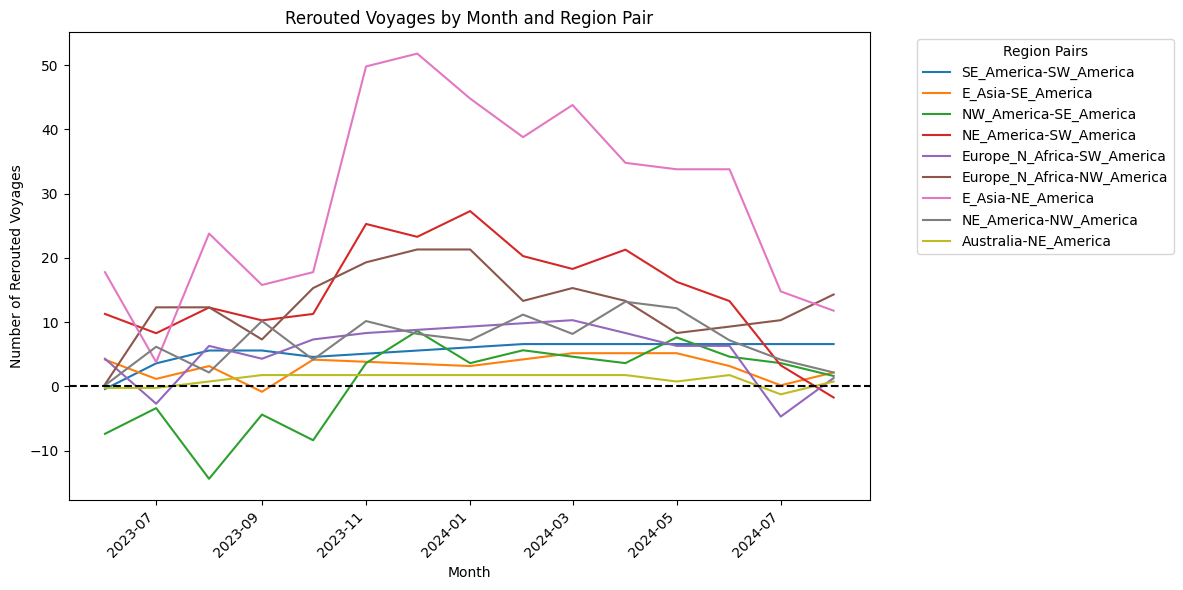

In [36]:
# Graph of the rerouted voyages per month and region pair
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.lineplot(x='proxy_transit_month', y='rerouted_voy', hue='region_pairs', data=Bulk_PA_ML_5_ElNino)
plt.title('Rerouted Voyages by Month and Region Pair')
plt.xlabel('Month')
plt.ylabel('Number of Rerouted Voyages')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Region Pairs', bbox_to_anchor=(1.05, 1), loc='upper left')
# Add horizontal line at y=0
plt.axhline(0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

If rerouted voyage is negative this means that the number of transits during El-Nino is higher than the number of transits before El-Nino. Therefore, this increase would already have been observed in the transits during El-Nino and no change has to be made. We change the number of rerouted voyages to 0 if the difference between the forecast and the data is negative.

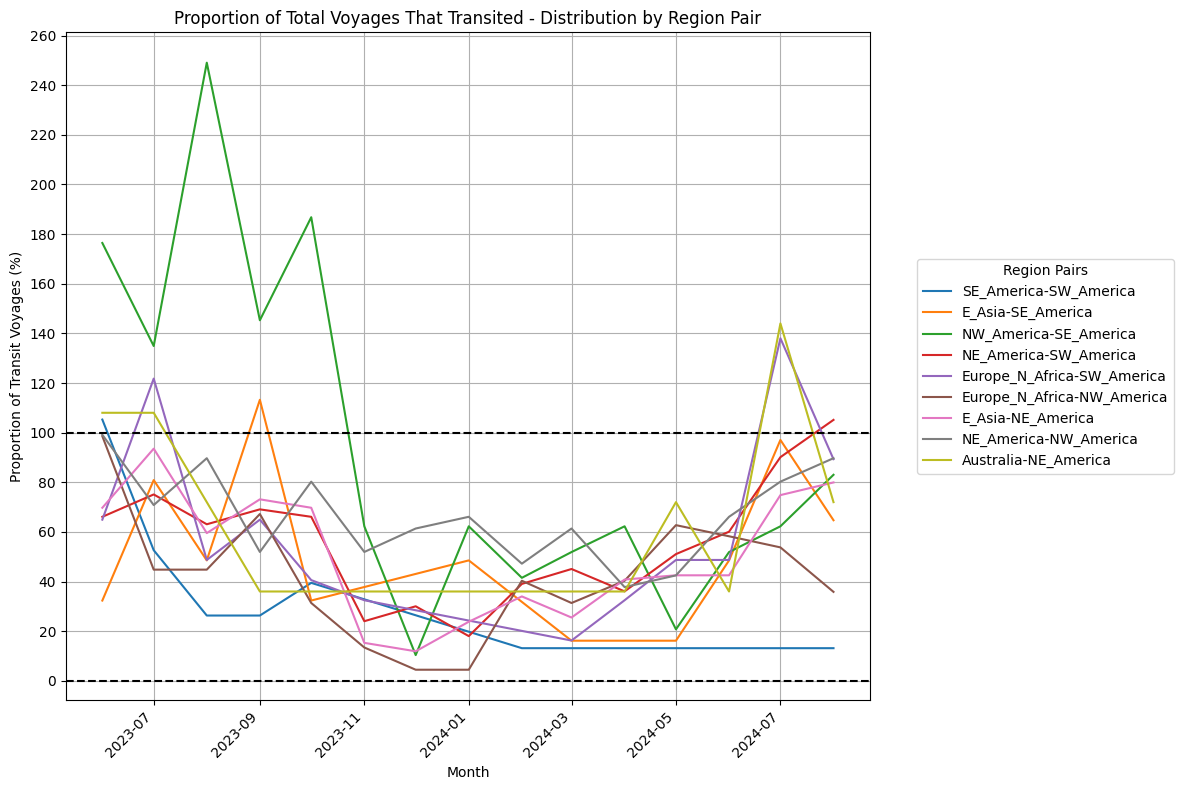

In [37]:
# Create a new DataFrame with the necessary columns
Bulk_PA_ML_5_ElNino_percentage = Bulk_PA_ML_5_ElNino[['proxy_transit_month', 'region_pairs', 'number_transits', 'forecast']].copy()

# Calculate the percentage of transits in the new DataFrame
Bulk_PA_ML_5_ElNino_percentage['transit_percentage'] = (Bulk_PA_ML_5_ElNino_percentage['number_transits'] / (Bulk_PA_ML_5_ElNino_percentage['forecast'])) * 100

# Graph of the transit voyages per month and region pair as percentage using the new DataFrame
plt.figure(figsize=(12, 8))
sns.lineplot(x='proxy_transit_month', y='transit_percentage', hue='region_pairs', data=Bulk_PA_ML_5_ElNino_percentage)
plt.title('Proportion of Total Voyages That Transited - Distribution by Region Pair')
plt.xlabel('Month')
plt.ylabel('Proportion of Transit Voyages (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Region Pairs', bbox_to_anchor=(1.05, 1), loc='upper left')
# Add a horizontal lines
plt.axhline(100, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.legend(title='Region Pairs', bbox_to_anchor=(1.05, 0.5), loc='center left')

# Set the y-axis tick locator to show steps of 10
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(20))
plt.grid(True)
plt.tight_layout()
plt.show()

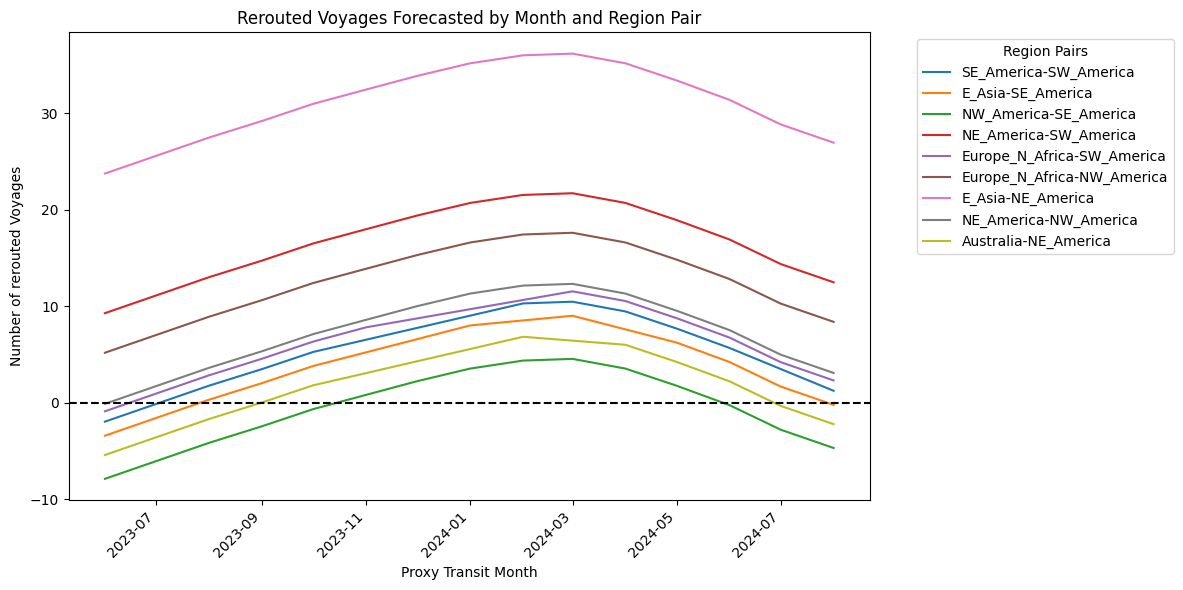

In [38]:
# Graph of the rerouted voyages per month and region pair
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.lineplot(x='proxy_transit_month', y='forecast_rerouted_voy', hue='region_pairs', data=Bulk_PA_ML_5_ElNino)
plt.title('Rerouted Voyages Forecasted by Month and Region Pair')
plt.xlabel('Proxy Transit Month')
plt.ylabel('Number of rerouted Voyages')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Region Pairs', bbox_to_anchor=(1.05, 1), loc='upper left')
# Add horizontal line at y=0
plt.axhline(0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

In [39]:
# Scatter plot of the forecast, forecastElNino and number_transits by proxi_transit_month
# Group by proxi transit month
grouped_data = Bulk_PA_ML_5_ElNino.groupby('proxy_transit_month').agg({
    'forecast': 'sum',
    'forecastElNino': 'sum',
    'number_transits': 'sum'
}).reset_index()

# Scatter plot


In [40]:
# Set 'rerouted_voy' to 0 if the difference is negative
Bulk_PA_ML_5_ElNino['rerouted_voy'] = Bulk_PA_ML_5_ElNino['rerouted_voy'].apply(lambda x: max(0, x))

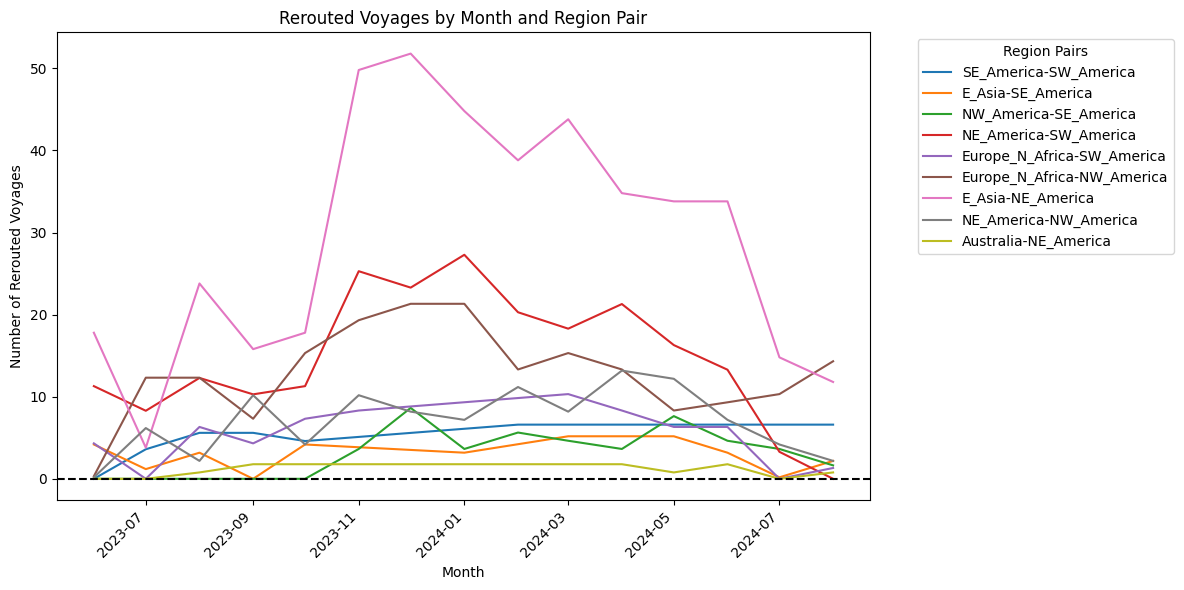

In [41]:
# Graph of the rerouted voyages per month and region pair
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.lineplot(x='proxy_transit_month', y='rerouted_voy', hue='region_pairs', data=Bulk_PA_ML_5_ElNino)
plt.title('Rerouted Voyages by Month and Region Pair')
plt.xlabel('Month')
plt.ylabel('Number of Rerouted Voyages')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Region Pairs', bbox_to_anchor=(1.05, 1), loc='upper left')
# Add horizontal line at y=0
plt.axhline(0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

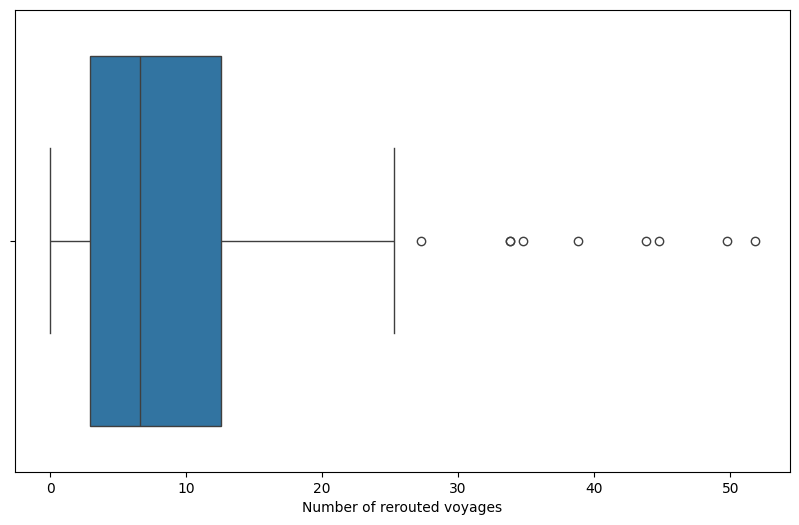

In [42]:
# Box plot of rerouted_voy
plt.figure(figsize=(10, 6))
sns.boxplot(x='rerouted_voy', data=Bulk_PA_ML_5_ElNino)
plt.xlabel('Number of rerouted voyages')
plt.show()

In [43]:
Bulk_PA_ML_5_ElNino[Bulk_PA_ML_5_ElNino['rerouted_voy'] <= 0]

proxy_transit_month                region_pairs  voy_intake_sum  \
467          2023-06-01       SE_America-SW_America          284786   
469          2023-06-01       NW_America-SE_America          836387   
475          2023-06-01        Australia-NE_America          114297   
481          2023-07-01  Europe_N_Africa-SW_America          444136   
483          2023-07-01       NW_America-SE_America          639617   
484          2023-07-01        Australia-NE_America           90724   
492          2023-08-01       NW_America-SE_America         1204497   
494          2023-09-01       NW_America-SE_America          796947   
499          2023-09-01           E_Asia-SE_America          334484   
511          2023-10-01       NW_America-SE_America          880965   
570          2024-07-01        Australia-NE_America          148376   
574          2024-07-01  Europe_N_Africa-SW_America          505819   
584          2024-08-01       NE_America-SW_America         1518567   

     number_transits   ONI  ONI_lag_1  ONI_lag_2  ONI_lag_3  water_level_m  \
467                8  0.77       0.48       0.16      -0.15      24.318570   
469               17  0.77       0.48       0.16      -0.15      24.318570   
475                3  0.77       0.48       0.16      -0.15      24.318570   
481               15  1.07       0.77       0.48       0.16      24.242710   
483               13  1.07       0.77       0.48       0.16      24.242710   
484                3  1.07       0.77       0.48       0.16      24.242710   
492               24  1.32       1.07       0.77       0.48      24.263063   
494               14  1.56       1.32       1.07       0.77      24.309222   
499                7  1.56       1.32       1.07       0.77      24.309222   
511               18  1.78       1.56       1.32       1.07      24.311831   
570                4  0.04       0.15       0.39       0.71      25.561315   
574               17  0.04       0.15       0.39       0.71      25.561315   
584               35 -0.11       0.04       0.15       0.39      26.031493   

     water_level_m_lag_1  water_level_m_lag_2  water_level_m_lag_3  \
467            24.667956            25.300737            25.745768   
469            24.667956            25.300737            25.745768   
475            24.667956            25.300737            25.745768   
481            24.318570            24.667956            25.300737   
483            24.318570            24.667956            25.300737   
484            24.318570            24.667956            25.300737   
492            24.242710            24.318570            24.667956   
494            24.263063            24.242710            24.318570   
499            24.263063            24.242710            24.318570   
511            24.309222            24.263063            24.242710   
570            25.030379            24.602571            24.476050   
574            25.030379            24.602571            24.476050   
584            25.561315            25.030379            24.602571   

         IFO380  Coal_Australian  Soybeans  Maize_Corn  Wheat_HRW  \
467  489.318182           139.42    591.89  266.867798     345.50   
469  489.318182           139.42    591.89  266.867798     345.50   
475  489.318182           139.42    591.89  266.867798     345.50   
481  521.595238           140.63    633.85  242.384839     345.50   
483  521.595238           140.63    633.85  242.384839     345.50   
484  521.595238           140.63    633.85  242.384839     345.50   
492  579.217391           152.61    583.93  207.607148     315.82   
494  590.976190           162.47    619.04  223.807080     314.68   
499  590.976190           162.47    619.04  223.807080     314.68   
511  551.068182           142.12    529.57  230.696480     298.10   
570  540.739130           137.55    469.63  177.429214     260.26   
574  540.739130           137.55    469.63  177.429214     260.26   
584  510.795455           145.76    40

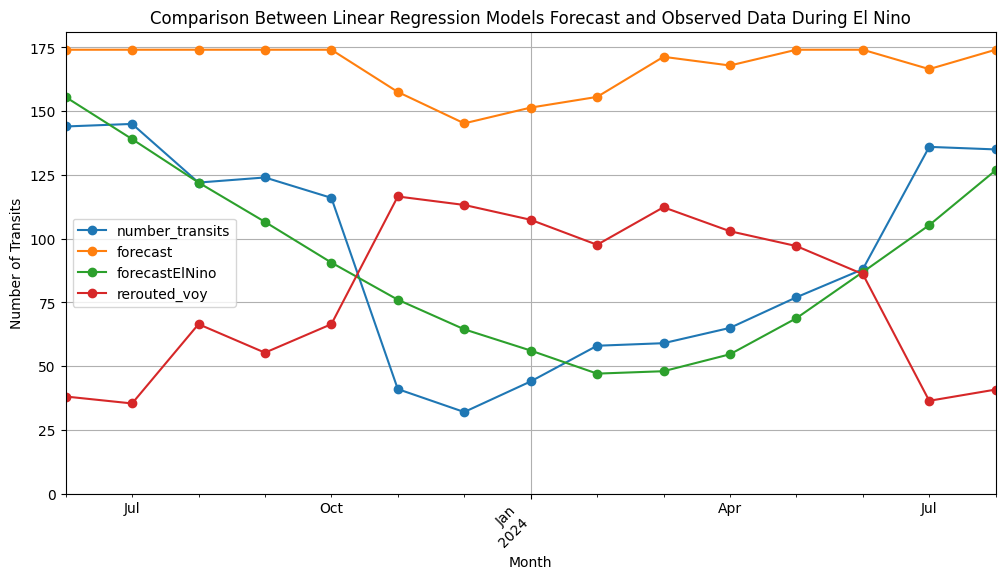

In [44]:
# Graph with forecasted data of the two linera regression models and  observed data
monthly_data = Bulk_PA_ML_5_ElNino.groupby('proxy_transit_month').sum(numeric_only=True).reset_index()

# Plot the data
monthly_data.plot(x='proxy_transit_month', y=['number_transits', 'forecast', 'forecastElNino', 'rerouted_voy'],
                  kind='line', marker='o', figsize=(12, 6),
                  title='Comparison Between Linear Regression Models Forecast and Observed Data During El Nino')

plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.xlabel('Month')
plt.ylabel('Number of Transits')
plt.ylim(bottom=0)
plt.show()




### **Validity of the LR model**

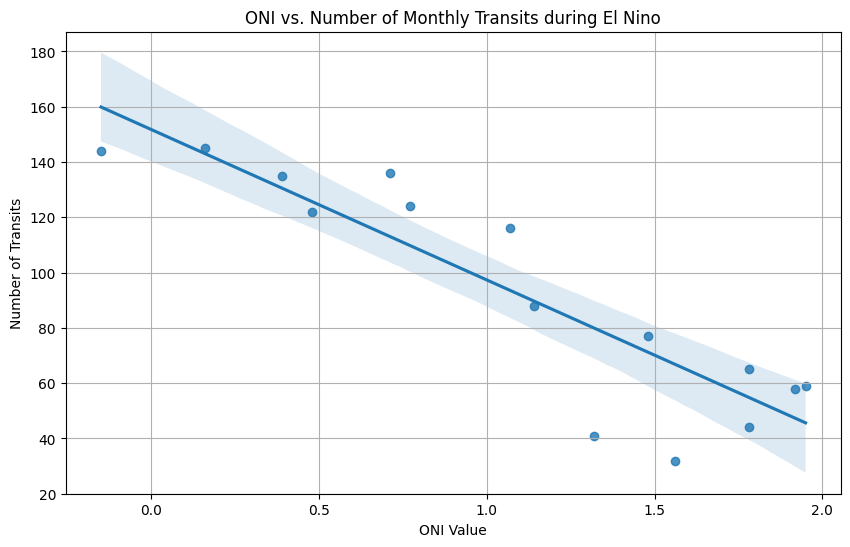

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aggregate the number_transits and ONI_lag_3 by proxy_transit_month
monthly_data_elnino = Bulk_PA_ML_5_ElNino.groupby('proxy_transit_month').agg(
    number_transits=('number_transits', 'sum'),
    ONI_lag_3=('ONI_lag_3', 'mean')
).reset_index()

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='ONI_lag_3', y='number_transits', data=monthly_data_elnino)
plt.title('ONI vs. Number of Monthly Transits during El Nino')
plt.xlabel('ONI Value')
plt.ylabel('Number of Transits')
plt.grid(True)
plt.show()

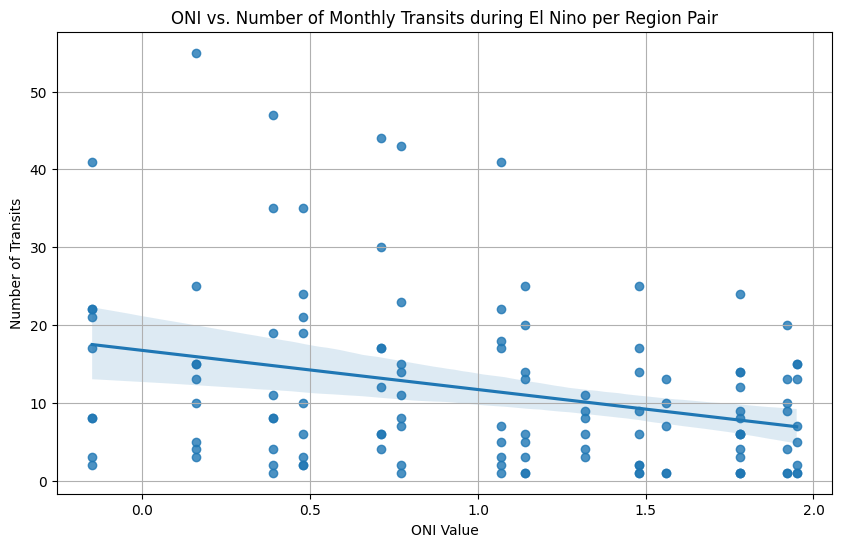

In [46]:
# Scatter plot of region pair monthly transit
plt.figure(figsize=(10, 6))
sns.regplot(x='ONI_lag_3', y='number_transits', data=Bulk_PA_ML_5_ElNino)
plt.title('ONI vs. Number of Monthly Transits during El Nino per Region Pair')
plt.xlabel('ONI Value')
plt.ylabel('Number of Transits')
plt.grid(True)
plt.show()

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Assuming Bulk_PA_ML_5_ElNino is already loaded and available

# Select the variables
X = monthly_data_elnino[['ONI_lag_3']]
y = monthly_data_elnino['number_transits']

# Handle potential NaN values by dropping rows with NaNs in either column
data_for_r2 = monthly_data_elnino[['ONI_lag_3', 'number_transits']].dropna()
X_cleaned = data_for_r2[['ONI_lag_3']]
y_cleaned = data_for_r2['number_transits']


# Fit a simple linear regression model
model = LinearRegression()
model.fit(X_cleaned, y_cleaned)

# Predict on the cleaned data
y_pred = model.predict(X_cleaned)

# Calculate the R-squared score
r2 = r2_score(y_cleaned, y_pred)

print(f"R-squared between ONI_lag_3 and number_transits: {r2}")

R-squared between ONI_lag_3 and number_transits: 0.7958678287449246


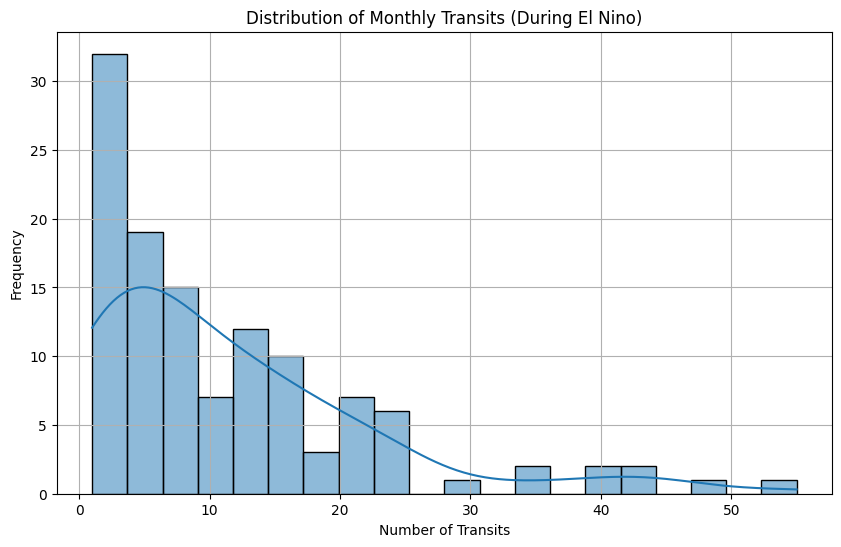

In [48]:
# Distribution of monthly trnasits histogram during El Nino
plt.figure(figsize=(10, 6))
sns.histplot(data=Bulk_PA_ML_5_ElNino, x='number_transits', bins=20, edgecolor='black', kde=True)

plt.title('Distribution of Monthly Transits (During El Nino)')
plt.xlabel('Number of Transits')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

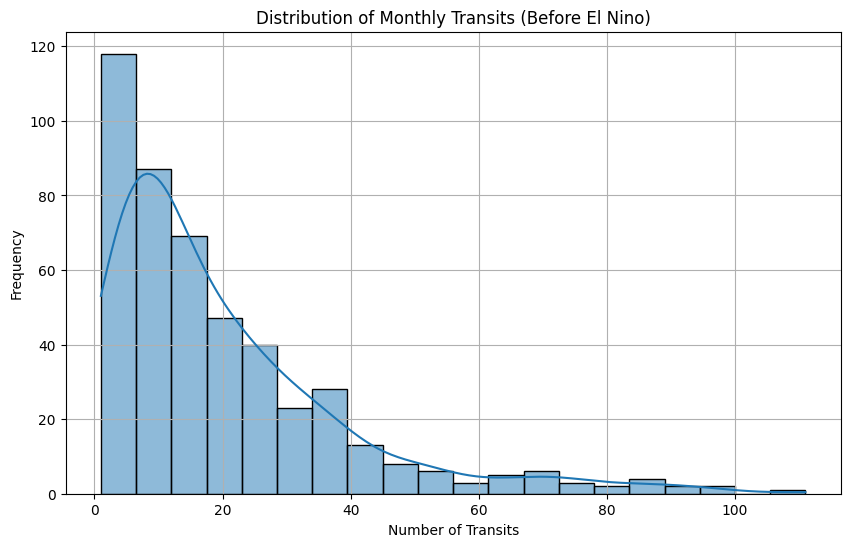

In [49]:
# Distribution # Distribution of monthly trnasits histogram before El Nino

plt.figure(figsize=(10, 6))
sns.histplot(data=Bulk_PA_ML_5_normal, x='number_transits', bins=20, edgecolor='black', kde=True)

plt.title('Distribution of Monthly Transits (Before El Nino)')
plt.xlabel('Number of Transits')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [50]:
# Verification of the accuracy LR model - Apply the LR model to the whole dataset
# Initialize the 'forecast' column with NaNs
Bulk_PA_ML_5['forecast'] = np.nan

# Loop through each row of Bulk_PA_ML_5 using the index
for index in Bulk_PA_ML_5.index:
    # Initialize the sum with the intercept value
    sum_value = LR_5_normal_params_df['Intercept'].iloc[0]

    # Loop through each column of LR_5_normal_params_df (excluding 'Intercept')
    for column_name in LR_5_normal_params_df.columns[1:]:
        # Get the corresponding column value from Bulk_PA_ML_5
        # Use .loc with the index and column name
        column_value = Bulk_PA_ML_5.loc[index, column_name]

        # Multiply the column value with the parameter value and add to the sum
        sum_value += LR_5_normal_params_df[column_name].iloc[0] * column_value

    # Assign the final sum to the 'forecast' column for the current row
    Bulk_PA_ML_5.loc[index, 'forecast'] = sum_value

# Create a rerouted voyage column - difference between forecast and actual number of transits
Bulk_PA_ML_5['delta'] = Bulk_PA_ML_5['forecast'] - Bulk_PA_ML_5['number_transits']

# Display the DataFrame with the forecast column
display(Bulk_PA_ML_5.head())

proxy_transit_month                region_pairs  voy_intake_sum  \
0          2019-01-01        Australia-NE_America          167605   
1          2019-01-01           E_Asia-NE_America         1497212   
2          2019-01-01           E_Asia-SE_America          148626   
3          2019-01-01  Europe_N_Africa-NW_America          905399   
4          2019-01-01  Europe_N_Africa-SW_America          339825   

   number_transits   ONI  ONI_lag_1  ONI_lag_2  ONI_lag_3  water_level_m  \
0                5  0.75       0.81        0.9       0.76      26.188514   
1               34  0.75       0.81        0.9       0.76      26.188514   
2                4  0.75       0.81        0.9       0.76      26.188514   
3               19  0.75       0.81        0.9       0.76      26.188514   
4               11  0.75       0.81        0.9       0.76      26.188514   

   water_level_m_lag_1  water_level_m_lag_2  water_level_m_lag_3  IFO380  \
0            26.786906            26.810513            26.664789   406.0   
1            26.786906            26.810513            26.664789   406.0   
2            26.786906            26.810513            26.664789   406.0   
3            26.786906            26.810513            26.664789   406.0   
4            26.786906            26.810513            26.664789   406.0   

   Coal_Australian  Soybeans  Maize_Corn   Wheat_HRW  Phosphate_rock  Copper  \
0            98.56    381.96  166.743164  209.806356           102.5  5939.1   
1            98.56    381.96  166.743164  209.806356           102.5  5939.1   
2            98.56    381.96  166.743164  209.806356           102.5  5939.1   
3            98.56    381.96  166.743164  209.806356           102.5  5939.1   
4            98.56    381.96  166.743164  209.806356           102.5  5939.1   

   Soybean_meal       Sugar   Urea  Potassium_chloride    Zinc  Wood_Pellets  \
0        362.01  563.721334  260.0               215.5  2569.7         273.9   
1        362.01  563.721334  260.0               215.5  2569.7         273.9   
2        362.01  563.721334  260.0               215.5  2569.7         273.9   
3        362.01  563.721334  260.0               215.5  2569.7         273.9   
4        362.01  563.721334  260.0               215.5  2569.7         273.9   

   Coking_Coal  HRC_Steel   Steel  Petroleum_Coke  Salt  voy_sea_duration_h  \
0       185.15      694.0  534.94            90.0  25.0          760.456667   
1       185.15      694.0  534.94            90.0  25.0          977.374020   
2       185.15      694.0  534.94            90.0  25.0         1127.104167   
3       185.15      694.0  534.94            90.0  25.0          808.073684   
4       185.15      694.0  534.94            90.0  25.0          667.598485   

    distance_94  shortest_distance_nm  shortest_distance_day  \
0   9329.314167                9423.0                 30.200   
1  11627.729250               10309.0                 33.040   
2  12639.290333                8463.0                 27.130   
3   9791.127333                8064.5                 25.845   
4   8659.646667                8023.0                 25.710   

   second_shortest_distance_nm  second_shortest_distance_day  rerouting_nm  \
0                      13778.0                         44.16        4355.0   
1                      16008.0                         51.31        5699.0   
2                      14312.0                         45.87        5849.0   
3                      13603.5                         43.60        5539.0   
4                      11007.0                         35.28        2984.0   

   rerouting_day  vsl_dwt  fuel_consumption_mt   cargo_value   canal_fee  \
0         13.960  35550.0           664.699685  4.877738e+06  139087.500   
1         18.270  55564.0           919.193310  1.860352e+07  198819.425   
2         18.740  43999.0          1050.212538  5.119287e+06  165052.100   
3         17.755  55090.0           703.772659  1.427129e+07  198003.500   
4 

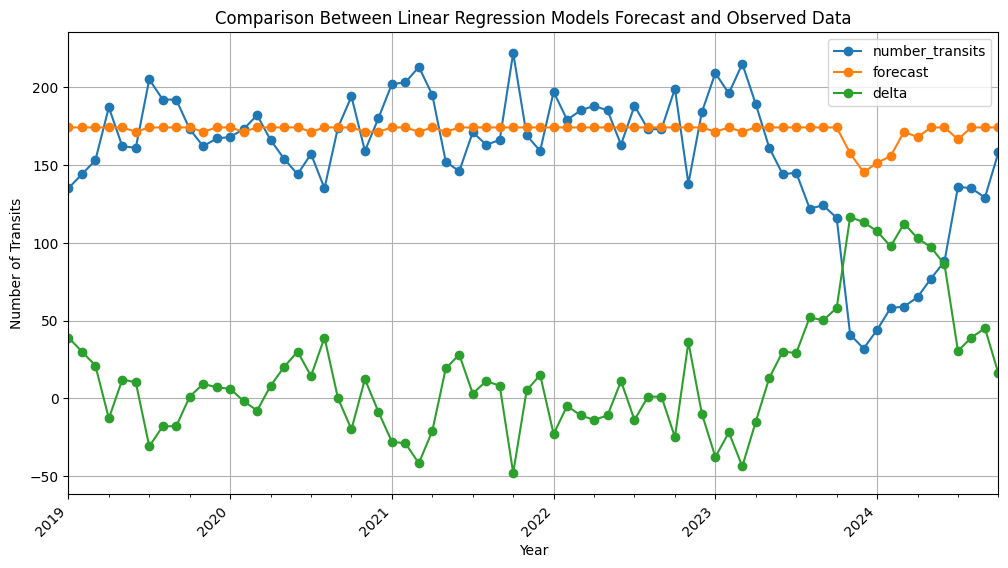

In [51]:
# Group and sum data by month
monthly_data = Bulk_PA_ML_5.groupby('proxy_transit_month').sum(numeric_only=True).reset_index()

# Remove the last 2 months
monthly_data = monthly_data[:-2]

# Plot the data
monthly_data.plot(x='proxy_transit_month', y=['number_transits', 'forecast', 'delta'],
                  kind='line', marker='o', figsize=(12, 6),
                  title='Comparison Between Linear Regression Models Forecast and Observed Data')

plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Number of Transits')
plt.show()

In [52]:
# As the LR model looks valid, we are now ready to estimate the cost of deviated vessels
# Bulk_PA_ML_5_ElNino to parquet
Bulk_PA_ML_5_ElNino.to_parquet('Bulk_rerouted.parquet')

## **ML6: statistical Linear Regression** - top commodity group

### **Before El-Nino model**

In [53]:
#Read Bulk_PA_ML_6
Bulk_PA_ML_6 = pd.read_parquet('Bulk_PA_ML_6.parquet')

# Sort the data by date
Bulk_PA_ML_6 = Bulk_PA_ML_6.sort_values(by=['proxy_transit_month'])

# Convert proxy_transit_month to period M
Bulk_PA_ML_6['proxy_transit_month'] = Bulk_PA_ML_6['proxy_transit_month'].dt.to_timestamp()

# Filter the data to exclude El-Nino data
Bulk_PA_ML_6 = Bulk_PA_ML_6[Bulk_PA_ML_6['proxy_transit_month'] >= '2023-06-01']

# Create a TimeSeriesSplit object with n_splits=5
tscv = TimeSeriesSplit(n_splits=5)

# Define the formula for the model
formula = 'number_transits ~ commodity_group_top5 + ONI_lag_3 + rain_season_2nd_half + VLSFO + Wheat_HRW'
#formula = 'number_transits ~ year + month + region_pairs + ONI_lag_3 + water_level_m_lag_3 + IFO380 + Wheat_HRW'

# Iterate through the splits and train/evaluate the model
for train_index, test_index in tscv.split(Bulk_PA_ML_6):
    train_data = Bulk_PA_ML_6.iloc[train_index]
    test_data = Bulk_PA_ML_6.iloc[test_index]

    # Fit the model using smf.ols
    model_ml_6_ElNino = smf.ols(formula=formula, data=train_data).fit()

    # Make predictions
    y_pred = model_ml_6_ElNino.predict(test_data)

# Store the last model's parameters
LR_6_ElNino_params = model_ml_6_ElNino.params

# Print model summary (includes parameters and significance)
print(model_ml_6_ElNino.summary())

                            OLS Regression Results                            
Dep. Variable:        number_transits   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     29.90
Date:                Tue, 27 May 2025   Prob (F-statistic):           1.72e-22
Time:                        22:50:28   Log-Likelihood:                -277.57
No. Observations:                  93   AIC:                             575.1
Df Residuals:                      83   BIC:                             600.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

The Adj. R-squared is high, however, the coefficients are not logical. Therefore, ML 5 with region_pairs is better.

### **El_Nino model**